# Проект

---

Вы работаете в IT-компании, которая выполняет на заказ проекты по машинному обучению. К вам обратился фермер, владелец молочного хозяйства «Вольный луг». Он хочет купить бурёнок, чтобы расширить поголовье стада коров. Для этого он заключил выгодный контракт с ассоциацией пастбищ «ЭкоФерма».

Условия позволяют фермеру очень тщательно отобрать коров. Он определяет качество молока по строгой методике, и при этом ему нужно выполнять свой план развития молочного хозяйства. Фермер хочет, чтобы каждая бурёнка давала **не менее 6000 килограммов молока в год**, а её **надой был вкусным** — строго по его критериям, ничуть не хуже. А продавцы и технологи так и норовят приукрасить своих коровок!

Поэтому он просит вас **разработать модель машинного обучения**, которая поможет ему управлять рисками и принимать объективное решение о покупке. «ЭкоФерма» готова предоставить подробные данные о своих коровах. Вам нужно создать две прогнозные модели для отбора бурёнок в поголовье:

> Первая будет прогнозировать возможный удой коровы (целевой признак - ***удой***)

> Вторая рассчитывать вероятность получить вкусное молоко от коровы (целевой признак - ***вкус молока***)

---

# План работ

- [Шаг 1. Загрузка данных](#section_1)

- [Шаг 2. Предобработка данных](#section_2)

- [Шаг 3. Исследовательский анализ данных](#section_3)

- [Шаг 4. Корреляционный анализ](#section_4)

- [Шаг 5. Обучение модели линейной регрессии](#section_5)

- [Шаг 6. Обучение модели логистической регрессии](#section_6)

- [Шаг 7. Итоговый выводы](#section_7)

---

In [1]:
!pip install phik

<a id='section_1'></a>

## Загрузка данных

In [2]:
#Импортируем библиотеки:

#Для работы с таблиными данными и массивами:
import pandas as pd
import numpy as np

#Для построения графиков и визуализации:
import matplotlib.pyplot as plt
import seaborn as sns

#Для определения коэффициента Спирмена:
from scipy.stats import spearmanr
from scipy import stats as st

#Библиотека для корреляционного анализа:
import phik

#Библиотека машинного обучения:

#Разделение массива на выборки:
from sklearn.model_selection import train_test_split

#Предобработка данныех:
from sklearn.preprocessing import OneHotEncoder, StandardScaler

#Модель линейной регрессии и логистической регрессии::
from sklearn.linear_model import LinearRegression, LogisticRegression

#Модель мультиклассовой лог.рег:
from sklearn.multiclass import OneVsRestClassifier

#Метрики:
from sklearn.metrics import (
    r2_score,
    mean_squared_error,
    mean_absolute_error,
    confusion_matrix,
    accuracy_score,
    recall_score,
    precision_score
)

In [3]:
#Считываем и распаковываем исходные датасеты:
#Считываем с сети:
try:
    #Файл содержащий данные о стаде фермера на текущий момент:
    df_main = pd.read_csv('https://code.s3.yandex.net/datasets/ferma_main.csv', sep=';', decimal=',')
    
    #Файл, который хранит имя папы каждой коровы в стаде фермера:
    df_dad = pd.read_csv('https://code.s3.yandex.net/datasets/ferma_dad.csv', sep=';', decimal=',')
    
    #Файл с данными о коровах «ЭкоФермы»:
    df_cow = pd.read_csv('https://code.s3.yandex.net/datasets/cow_buy.csv', sep=';', decimal=',')
    
#В случае изменения ссылки или отсутсвия сети:
except:
    df_main = pd.read_csv('/datasets/ferma_main.csv', sep=';', decimal=',')
    df_dad = pd.read_csv('/datasets/ferma_dad.csv', sep=';', decimal=',')
    df_cow = pd.read_csv('/datasets/cow_buy.csv', sep=';', decimal=',')
    
#Используем специальную команду отображения таблиц, для наглядного просмотра всех данных:    
pd.set_option('display.max_columns', None)

### Изучаем общую информацию из файла ferma_main.csv

**Выведем первые 10 строк и общую информацию датафрейма, проанализируем данные, с которыми будем работать**

In [4]:
df_main.head(10)

id  Удой, кг  ЭКЕ (Энергетическая кормовая единица)  Сырой протеин, г  \
0   1      5863                                   14.2              1743   
1   2      5529                                   12.8              2138   
2   3      5810                                   14.0              1854   
3   4      5895                                   12.4              2012   
4   5      5302                                   12.8              1675   
5   6      5254                                   12.7              1806   
6   7      5910                                   13.2              1792   
7   8      6179                                   14.7              1806   
8   9      6783                                   14.2              1918   
9  10      5339                                   13.4              1791   

   СПО (Сахаро-протеиновое соотношение)           Порода Тип пастбища  \
0                                 0.890   Вис Бик Айдиал    Равнинное   
1                                 0.890   Вис Бик Айдиал    Равнинные   
2                                 0.885  РефлешнСоверинг    Холмистое   
3                                 0.885  РефлешнСоверинг    Холмистое   
4                                 0.885   Вис Бик Айдиал    Равнинные   
5                                 0.885  РефлешнСоверинг    Холмистое   
6                                 0.885   Вис Бик Айдиал    Равнинные   
7                                 0.930   Вис Бик Айдиал    Равнинные   
8                                 0.940  РефлешнСоверинг    Холмистое   
9                                 0.895   Вис Бик Айдиал    Холмистое   

  порода папы_быка  Жирность,%  Белок,% Вкус молока      Возраст  
0           Айдиал        3.58    3.076      вкусно  более_2_лет  
1          Соверин        3.54    3.079      вкусно  менее_2_лет  
2          Соверин        3.59    3.074   не вкусно  более_2_лет  
3           Айдиал        3.40    3.075   не вкусно  более_2_лет  
4          Соверин        3.73    3.073      вкусно  менее_2_лет  
5          Соверин        3.13    3.078      вкусно  менее_2_лет  
6          Соверин        3.48    3.077      вкусно  более_2_лет  
7           Айдиал        3.55    3.076      вкусно  более_2_лет  
8           Айдиал        3.71    3.077      вкусно  более_2_лет  
9          Соверин        3.13    3.075      вкусно  менее_2_лет

**Переменуем столбцы датафрейма из кириллицы в латиницу, предерживая следующего соотвествия:**

- [x] id - ***id***
- [x] Удой, кг - ***milk_yield***
- [x] ЭКЕ (Энергетическая кормовая единица) - ***efu*** (energy_food_unit)
- [x] Сырой протеин, г - ***raw_protein***
- [x] СПО (Сахаро-протеиновое соотношение) - ***spr*** (sugar-protein ratio)
- [x] Порода - ***breed***
- [x] Тип пастбища - ***type_pasture***
- [x] порода папы_быка - ***dad_breed***
- [x] Жирность,% - ***fat_percent***
- [x] Белок,% - ***protein_percent***
- [x] Вкус молока - ***taste_milk***
- [x] Возраст - ***age***

In [5]:
#Переменуем названия столбцов как показано выше:
df_main.columns = ['id', 'milk_yield', 'efu', 'raw_protein', 
                   'spr', 'breed', 'type_pasture', 'dad_breed', 
                   'fat_percent', 'protein_percent', 'taste_milk', 'age']

In [6]:
#вывдем общую информацию о датафрейме:
df_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               634 non-null    int64  
 1   milk_yield       634 non-null    int64  
 2   efu              634 non-null    float64
 3   raw_protein      634 non-null    int64  
 4   spr              634 non-null    float64
 5   breed            634 non-null    object 
 6   type_pasture     634 non-null    object 
 7   dad_breed        634 non-null    object 
 8   fat_percent      634 non-null    float64
 9   protein_percent  634 non-null    float64
 10  taste_milk       634 non-null    object 
 11  age              634 non-null    object 
dtypes: float64(4), int64(3), object(5)
memory usage: 59.6+ KB


In [7]:
#Теперь названия столбцов в таблице принимают такой вид:
df_main.head()

id  milk_yield   efu  raw_protein    spr            breed type_pasture  \
0   1        5863  14.2         1743  0.890   Вис Бик Айдиал    Равнинное   
1   2        5529  12.8         2138  0.890   Вис Бик Айдиал    Равнинные   
2   3        5810  14.0         1854  0.885  РефлешнСоверинг    Холмистое   
3   4        5895  12.4         2012  0.885  РефлешнСоверинг    Холмистое   
4   5        5302  12.8         1675  0.885   Вис Бик Айдиал    Равнинные   

  dad_breed  fat_percent  protein_percent taste_milk          age  
0    Айдиал         3.58            3.076     вкусно  более_2_лет  
1   Соверин         3.54            3.079     вкусно  менее_2_лет  
2   Соверин         3.59            3.074  не вкусно  более_2_лет  
3    Айдиал         3.40            3.075  не вкусно  более_2_лет  
4   Соверин         3.73            3.073     вкусно  менее_2_лет

Итак, в файле ***ferma_main.csv*** хранятся данные о стаде фермера на текущий момент, датафрейм состоит из:

> количество строк - **634**

> количество столбцов - **12**

### Изучаем общую информацию из файла ferma_dad.csv

**Выведем первые 10 строк и общую информацию датафрейма**

In [8]:
df_dad.head(10)

id  Имя Папы
0   1    Буйный
1   2  Соловчик
2   3     Барин
3   4    Буйный
4   5     Барин
5   6     Барин
6   7  Соловчик
7   8  Геркулес
8   9    Буйный
9  10     Барин

In [9]:
#Переменуем столбцы:
df_dad.columns = ['id', 'name_dad']

In [10]:
#вывдем общую информацию о датафрейме:
df_dad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        629 non-null    int64 
 1   name_dad  629 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.0+ KB


В файле ***ferma_dad.csv*** хранится имя папы каждой коровы в стаде фермера, датафрейм состоит из:

> количество строк - **629**

> количество столбцов - **2**

### Изучаем общую информацию из файла cow_buy.csv

**Выведем первые 10 строк и общую информацию датафрейма**

In [11]:
df_cow.head(10)

Порода Тип пастбища порода папы_быка  Имя_папы  \
0   Вис Бик Айдиал    холмистое           Айдиал  Геркулес   
1   Вис Бик Айдиал    равнинное          Соверин    Буйный   
2  РефлешнСоверинг    равнинное          Соверин     Барин   
3  РефлешнСоверинг    холмистое           Айдиал    Буйный   
4  РефлешнСоверинг    равнинное           Айдиал    Буйный   
5  РефлешнСоверинг    равнинное          Соверин  Геркулес   
6   Вис Бик Айдиал    холмистое           Айдиал  Геркулес   
7   Вис Бик Айдиал    равнинное          Соверин    Буйный   
8  РефлешнСоверинг    равнинное          Соверин     Барин   
9  РефлешнСоверинг    холмистое           Айдиал    Буйный   

   Текущая_жирность,%  Текущий_уровень_белок,%      Возраст  
0                3.58                    3.076  более_2_лет  
1                3.54                    3.081  менее_2_лет  
2                3.59                    3.074  более_2_лет  
3                3.40                    3.061  более_2_лет  
4                3.64                    3.074  более_2_лет  
5                3.63                    3.053  менее_2_лет  
6                3.58                    3.076  более_2_лет  
7                3.57                    3.079  более_2_лет  
8                3.59                    3.074  более_2_лет  
9                3.40                    3.079  менее_2_лет

**Переменуем столбцы датафрейма из кириллицы в латиницу, предерживая следующего соотвествия:**

- [x] Порода - ***breed***
- [x] Тип пастбища - ***type_pasture***
- [x] порода папы_быка - ***dad_breed***
- [x] Имя_папы - ***name_dad***
- [x] Текущая_жирность,% - ***current_fat_percent***
- [x] Текущий_уровень_белок,% - ***current_protein_percent***
- [x] Возраст - ***age***

In [12]:
#Переменуем названия столбцов как показано выше:
df_cow.columns = ['breed', 'type_pasture', 'dad_breed', 'name_dad', 
                   'current_fat_percent', 'current_protein_percent', 'age']

In [13]:
#вывдем общую информацию о датафрейме:
df_cow.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   breed                    20 non-null     object 
 1   type_pasture             20 non-null     object 
 2   dad_breed                20 non-null     object 
 3   name_dad                 20 non-null     object 
 4   current_fat_percent      20 non-null     float64
 5   current_protein_percent  20 non-null     float64
 6   age                      20 non-null     object 
dtypes: float64(2), object(5)
memory usage: 1.2+ KB


In [14]:
#Теперь названия столбцов в таблице принимают такой вид:
df_cow.head()

breed type_pasture dad_breed  name_dad  current_fat_percent  \
0   Вис Бик Айдиал    холмистое    Айдиал  Геркулес                 3.58   
1   Вис Бик Айдиал    равнинное   Соверин    Буйный                 3.54   
2  РефлешнСоверинг    равнинное   Соверин     Барин                 3.59   
3  РефлешнСоверинг    холмистое    Айдиал    Буйный                 3.40   
4  РефлешнСоверинг    равнинное    Айдиал    Буйный                 3.64   

   current_protein_percent          age  
0                    3.076  более_2_лет  
1                    3.081  менее_2_лет  
2                    3.074  более_2_лет  
3                    3.061  более_2_лет  
4                    3.074  более_2_лет

В файле ***cow_buy.csv*** хранятся данные о коровах «ЭкоФермы», датафрейм состоит из:

> количество строк - **20**

> количество столбцов - **7**

**Анализируя исходные файлы, можно сделать следующий вывод:**

- Предоставленные данные соотвествуют описанию поставленной задачи

- Сразу можно заметить, в категориальных переменных таблиц неправильный формат значений (устраним на этапе предобработки)

- Самый объемный датафрейм с общей информацией ***ferma_main.csv*** состоит из **634 строк** и **12 столбцов**

- Файлы ***ferma_main.csv*** и ***cow_buy.csv*** - имеют одинаковые столбцы, единственное отличие заключается в том, что второй файл несет в себе информацию о коровах, которых мы будем покупать

- Общий объем данных - **небольшой**

<a id='section_2'></a>

## Предобработка данных

Создадим функцию ***check*** до/после обработки данных, для отслеживания процента потерянных данных после обработки:

In [15]:
#Создадим глобальную переменную, в которой сохраним исходное количество строк всех таблиц:
s = df_main.shape[0] + df_dad.shape[0] + df_cow.shape[0]

#Функция check
def check(df1, df2, df3):
    s_after = df1.shape[0] + df2.shape[0] + df3.shape[0]
    print(f'Количество удаленных строк: {s - s_after}')
    print(f'Процент потерянных данных от общего числа: {(1 - s_after/s)*100:.2f}%')
    pass

#Вызовем функцию и проверим работу
check(df_main, df_dad, df_cow)

Количество удаленных строк: 0
Процент потерянных данных от общего числа: 0.00%


### Просмотр данных

In [16]:
#Приведем все столбцы всех датафреймов(с строковыми значениями) к нижнему регистру:
for name in [df_main, df_dad, df_cow]:
    for col in name:
        if type(name[col].values[0]) == str:
            name[col] = name[col].str.lower()   

In [17]:
#Создадим функцию для просмотра уникальных категориальных значений по всем столбцам исходных датафреймов:
def uniq():
    i = 1
    for name in [df_main, df_dad, df_cow]:
        for col in name:
            if type(name[col].values[0]) == str:
                print(f'Датафрейм №{i}')
                print(f'Имя столбца: {col}')
                print(name[col].unique())
                print()
        i+=1
        pass
    
#Вызовем функцию:
uniq()

Датафрейм №1
Имя столбца: breed
['вис бик айдиал' 'рефлешнсоверинг']

Датафрейм №1
Имя столбца: type_pasture
['равнинное' 'равнинные' 'холмистое']

Датафрейм №1
Имя столбца: dad_breed
['айдиал' 'соверин' 'айдиалл']

Датафрейм №1
Имя столбца: taste_milk
['вкусно' 'не вкусно']

Датафрейм №1
Имя столбца: age
['более_2_лет' 'менее_2_лет']

Датафрейм №2
Имя столбца: name_dad
['буйный' 'соловчик' 'барин' 'геркулес']

Датафрейм №3
Имя столбца: breed
['вис бик айдиал' 'рефлешнсоверинг']

Датафрейм №3
Имя столбца: type_pasture
['холмистое' 'равнинное']

Датафрейм №3
Имя столбца: dad_breed
['айдиал' 'соверин']

Датафрейм №3
Имя столбца: name_dad
['геркулес' 'буйный' 'барин' 'соловчик']

Датафрейм №3
Имя столбца: age
['более_2_лет' 'менее_2_лет']



Из полученного списка, можно выделить ошибки:

> ***breed*** - породу "вис бик айдиал" и "рефлешнсоверинг" заменим на "айдиал" и "соверин"

> ***type_pasture*** - тип пастбища, имеет значения "равнинное" и "равнинные" - это один и тот же вид пастбищ, записанный по разному

> ***dad_breed*** - порода папы быка, имеет значения "айдиал" и "айдиалл" - это один и тот же вид, нужно заменить

In [18]:
#Исправим данные ошибки:
#для df_main
df_main['breed'] = df_main['breed'].replace('вис бик айдиал', 'айдиал')
df_main['breed'] = df_main['breed'].replace('рефлешнсоверинг', 'соверин')
df_main['type_pasture'] = df_main['type_pasture'].replace('равнинные', 'равнинное')
df_main['dad_breed'] = df_main['dad_breed'].replace('айдиалл', 'айдиал')
#для df_cow
df_cow['breed'] = df_cow['breed'].replace('вис бик айдиал', 'айдиал')
df_cow['breed'] = df_cow['breed'].replace('рефлешнсоверинг', 'соверин')

In [19]:
#Вызовем функцию uniq снова и посмотрим на изменения:
uniq()

Датафрейм №1
Имя столбца: breed
['айдиал' 'соверин']

Датафрейм №1
Имя столбца: type_pasture
['равнинное' 'холмистое']

Датафрейм №1
Имя столбца: dad_breed
['айдиал' 'соверин']

Датафрейм №1
Имя столбца: taste_milk
['вкусно' 'не вкусно']

Датафрейм №1
Имя столбца: age
['более_2_лет' 'менее_2_лет']

Датафрейм №2
Имя столбца: name_dad
['буйный' 'соловчик' 'барин' 'геркулес']

Датафрейм №3
Имя столбца: breed
['айдиал' 'соверин']

Датафрейм №3
Имя столбца: type_pasture
['холмистое' 'равнинное']

Датафрейм №3
Имя столбца: dad_breed
['айдиал' 'соверин']

Датафрейм №3
Имя столбца: name_dad
['геркулес' 'буйный' 'барин' 'соловчик']

Датафрейм №3
Имя столбца: age
['более_2_лет' 'менее_2_лет']



In [20]:
#Просмотрим уникальные значение по всем таблицам как для числовых так и для категориальных данных:
i = 1
for name in [df_main, df_dad, df_cow]:
    for col in name:
        if type(name[col].values[0]) == float or int:
            print(f'Датафрейм №{i}')
            print(f'Тип данных в столбце: {type(name[col].values[0])}')
            print(f'Имя столбца: {col}')
            print(name[col].unique())
            print()
    i+=1
        

Датафрейм №1
Тип данных в столбце: <class 'numpy.int64'>
Имя столбца: id
[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 22

> Все категориальные данные были приведены к нижнему регистру

> Найдены ошибки в записях данных - **устранены**

> Ошибок в числовых типах данных не найдено, округление и изменение типов **не потребовалось**

### Обработка пропусков

In [21]:
#Посмотрим на наличие пропусков во всех df:
for name in [df_main, df_dad, df_cow]:
    print(name.isna().sum())
    print()   

id                 0
milk_yield         0
efu                0
raw_protein        0
spr                0
breed              0
type_pasture       0
dad_breed          0
fat_percent        0
protein_percent    0
taste_milk         0
age                0
dtype: int64

id          0
name_dad    0
dtype: int64

breed                      0
type_pasture               0
dad_breed                  0
name_dad                   0
current_fat_percent        0
current_protein_percent    0
age                        0
dtype: int64



> Пропусков в табличных данных - **нет**

### Поиск дубликатов

In [22]:
#Проверим датафреймы на наличие явных дубликатов:
for name in [df_main, df_dad, df_cow]:
    print(name.duplicated().sum())
    print() 

5

0

4



У нас есть 5 дубликатов в ***df_main*** и 4 дубликата в ***df_cow***. Поскольку в таблице с коровами (на покупку) **мало** строк, стоит сделать предположение, что они разные. **Явные дубликаты** в данном случае не критичны, поэтому закоментируем удаление данный строк в дф **df_cow**, в последсвии, если это потребуется, можем удалить.

In [23]:
#Удалим явные дубликаты:
df_main = df_main.drop_duplicates()
#df_cow = df_cow.drop_duplicates()

In [24]:
#Снова сделаем проверку на наличие явных дубликатов:
for name in [df_main, df_dad, df_cow]:
    print(name.duplicated().sum(),'\n')

0 

0 

4 



Проверим на наличие дубликатов по подмножествам чиловых значений, без учета ***id***:

In [25]:
df_main.duplicated(['efu','raw_protein','fat_percent', 'spr', 'protein_percent']).sum()

0

In [26]:
df_cow.duplicated(['current_fat_percent','current_protein_percent']).sum()

4

По подмоножествам в df_cow определяются теже дубликаты, что и явные, оставим их

### Сводка

In [27]:
#Вызовем функцию check и посмотрим какой процент данных от изначального мы потеряли:
check(df_main, df_dad, df_cow)

Количество удаленных строк: 5
Процент потерянных данных от общего числа: 0.39%


**Вывод по предобработке данных:**

> Были просмотренны все типы данных, их изменения не потребовалось

> Все числовые значения лежат в допустимых диапозонах, выбивающихся данных - **нет**

> В категориальных данных были выявлены ошибки, связаные с неточностью заполнения, одни и теже значения были записаны по разному - данные ошибки **исправлены**

> Пропусков - **не выявлено**

> Дубликаты - найдено 5 дубликатов в ***data_main***  и 4 дубликата в ***data_cow*** - они **удалены**

> Дубликатов по определенным числовым подмножествам не найдено

> Процент удаленных данных составляет 0.39 % (оптимально 5~10%)

<a id='section_3'></a>

## Исследовательский анализ данных

### Анализ df_main

In [28]:
#Посмотрим общие статистические характеристики для всех числовых столбцов датафрейма df_main:
df_main.describe().style.format("{:,.4f}")

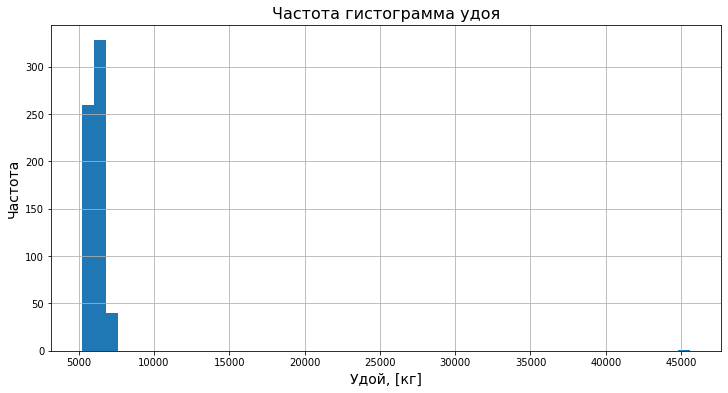

In [29]:
#
plt.figure(figsize=(12,6))
df_main['milk_yield'].plot(kind='hist', bins=50, grid=True)
plt.xlabel('Удой, [кг]', fontsize=14)
plt.ylabel('Частота', fontsize=14)
plt.title('Частота гистограмма удоя', fontsize=16)
plt.show()

In [30]:
#в столбце milk_yield есть аномальное значение:
df_main['milk_yield'].max()

45616

In [31]:
#удалим его с помощью среза
df_main = df_main.query('milk_yield < 8000')

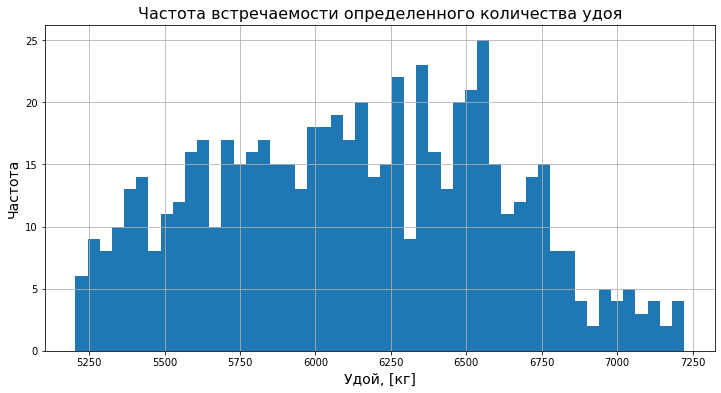

In [32]:
#После удаления аномального значения гистограмма примет вид:
plt.figure(figsize=(12,6))
df_main['milk_yield'].plot(kind='hist', bins=50, grid=True)
plt.xlabel('Удой, [кг]', fontsize=14)
plt.ylabel('Частота', fontsize=14)
plt.title('Частота встречаемости определенного количества удоя', fontsize=16)
plt.show()

> Распределение данных схоже с **Нормальным**

In [33]:
#Самое часто встречающееся значение:
df_main['milk_yield'].mode()[0]

6248

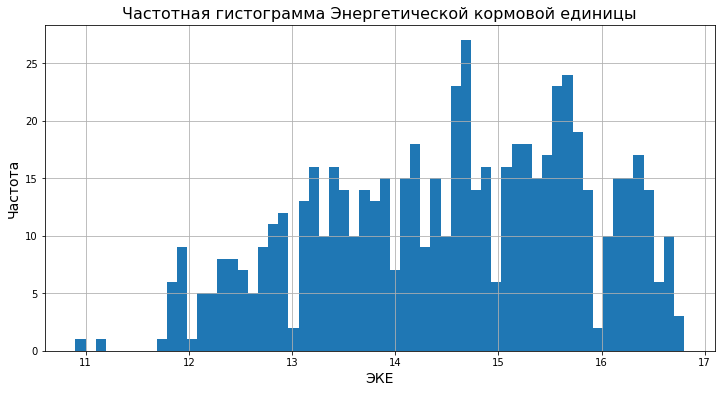

In [34]:
#Построим частотную гистограмму для Энергетической кормовой единицы:
plt.figure(figsize=(12,6))
df_main['efu'].plot(kind='hist', bins=60, grid=True)
plt.xlabel('ЭКЕ', fontsize=14)
plt.ylabel('Частота', fontsize=14)
plt.title('Частотная гистограмма Энергетической кормовой единицы', fontsize=16)
plt.show()

In [35]:
#Также имеются небольшие отклонения от общих данных, срежем их с помощью query:
df_main = df_main.query('efu > 11.2')

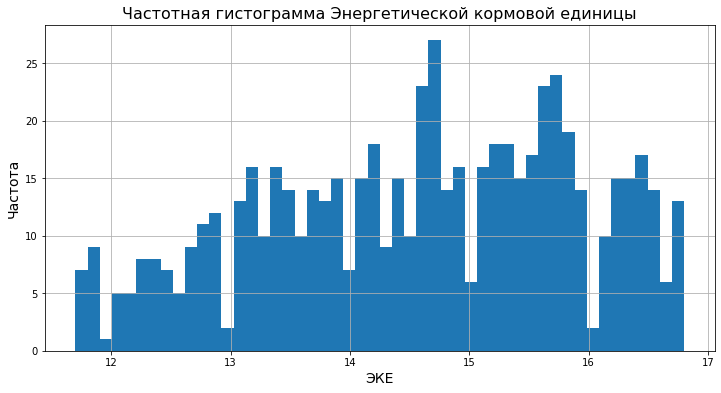

In [36]:
#Построим частотную гистограмму для Энергетической кормовой единицы:
plt.figure(figsize=(12,6))
df_main['efu'].plot(kind='hist', bins=50, grid=True)
plt.xlabel('ЭКЕ', fontsize=14)
plt.ylabel('Частота', fontsize=14)
plt.title('Частотная гистограмма Энергетической кормовой единицы', fontsize=16)
plt.show()

> Распределение данных схоже с **Нормальным**

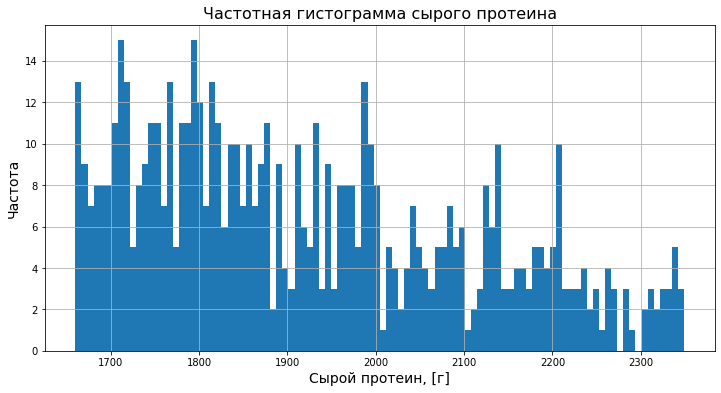

In [37]:
#Построим частотную гистограмму для сырого протеина:
plt.figure(figsize=(12,6))
df_main['raw_protein'].plot(kind='hist', bins=100, grid=True)
plt.xlabel('Сырой протеин, [г]', fontsize=14)
plt.ylabel('Частота', fontsize=14)
plt.title('Частотная гистограмма сырого протеина', fontsize=16)
plt.show()

> Распределение данных схоже с **Нормальным** смещенным влело

In [38]:
#Значение моды для сырого протеина:
df_main['raw_protein'].mode()[0]

1712

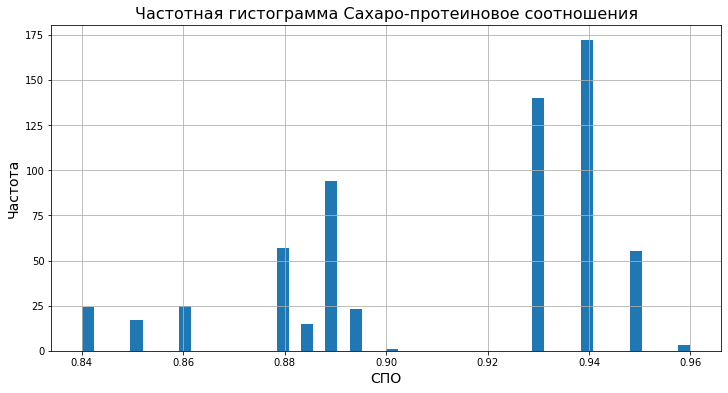

In [39]:
#Построим частотную гистограмму для сырого протеина:
plt.figure(figsize=(12,6))
df_main['spr'].plot(kind='hist', bins=50, grid=True)
plt.xlabel('СПО', fontsize=14)
plt.ylabel('Частота', fontsize=14)
plt.title('Частотная гистограмма Сахаро-протеиновое соотношения', fontsize=16)
plt.show()

> Из-за дискретный значений по гистограмме частотности сложно сказать, что данное распределение **Нормальное**

> Нормальное распределение - непрерывно, т.к. у нас значения дискретны, делаем вывод о том, что СПО распределен не нормально

In [40]:
#Данные лежат в небольшом диапозоне, отсортируем их и подсмотрим границы:
df_main['spr'].sort_values(ascending=True)

147    0.84
544    0.84
541    0.84
314    0.84
146    0.84
       ... 
226    0.95
263    0.95
620    0.96
44     0.96
190    0.96
Name: spr, Length: 626, dtype: float64

In [41]:
#Значение гистограммы больше соответвубт дискретным, выбросов не наблюдается, 
#диапазон значений от 0.84 ~ 0.96 - в пределах разумного, посмотрим на моду:
df_main['spr'].mode()[0]

0.94

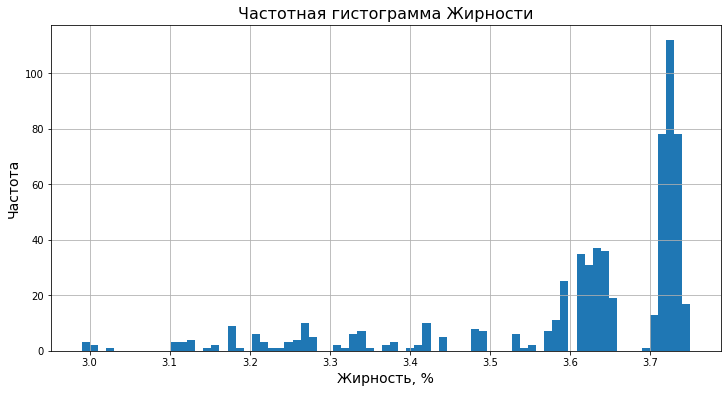

In [42]:
#Построим частотную гистограмму для жирности:
plt.figure(figsize=(12,6))
df_main['fat_percent'].plot(kind='hist', bins=75, grid=True)
plt.xlabel('Жирность, %', fontsize=14)
plt.ylabel('Частота', fontsize=14)
plt.title('Частотная гистограмма Жирности', fontsize=16)
plt.show()

> Распределение не является **нормальным**

In [43]:
#Мода значений Жирности:
df_main['fat_percent'].mode()[0]

3.72

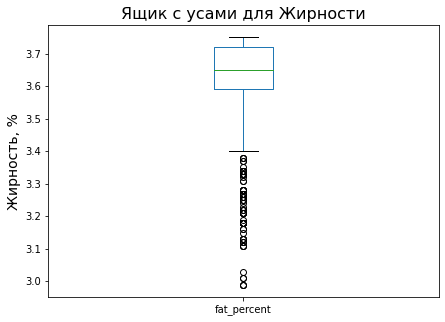

In [44]:
#Построим boxplot для Жирности, посмотрим на выбросы:
plt.figure(figsize=(7,5))
df_main['fat_percent'].plot(kind='box')
plt.xlabel('', fontsize=14)
plt.ylabel('Жирность, %', fontsize=14)
plt.title('Ящик с усами для Жирности', fontsize=16)
plt.show()

Итак, значения ниже 3.4 считаются - **выбросами**, но удалить их все не получится, т.к. они занимают большой объем данных, но если рассмотреть интервал от 3.0 до 3.8 - аналитически он лежит в пределах разумного, на этом этапе примем решение не избавиться от выбросов. Т.к. распределение не является нормальным, просто удалять данные значения - **ошибка**. Поэтому примем решение пока сохранить все выбросы в данной ситуации

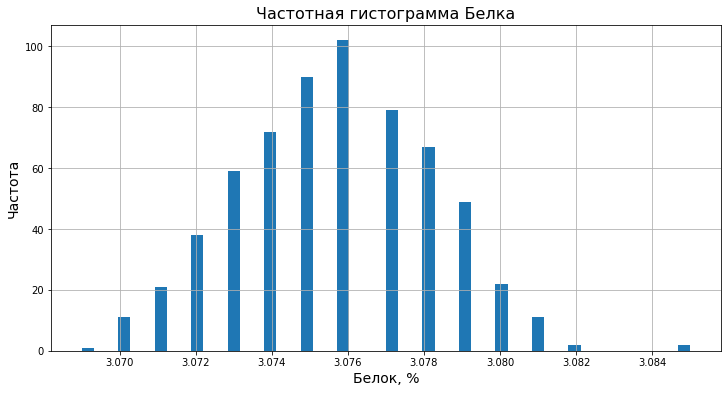

In [45]:
#Построим частотную гистограмму для Белка:
plt.figure(figsize=(12,6))
df_main['protein_percent'].plot(kind='hist', bins=50, grid=True)
plt.xlabel('Белок, %', fontsize=14)
plt.ylabel('Частота', fontsize=14)
plt.title('Частотная гистограмма Белка', fontsize=16)
plt.show()

In [46]:
#Имеются аномальные значения свыше 3.084, срежем их:
df_main = df_main.query(' 3.070 < protein_percent < 3.082')

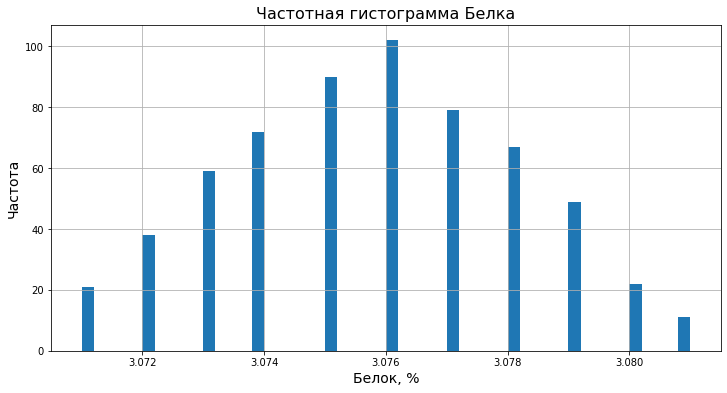

In [47]:
#Теперь гистограмма Белка примет вид:
plt.figure(figsize=(12,6))
df_main['protein_percent'].plot(kind='hist', bins=50, grid=True)
plt.xlabel('Белок, %', fontsize=14)
plt.ylabel('Частота', fontsize=14)
plt.title('Частотная гистограмма Белка', fontsize=16)
plt.show()

> распределение сильно схоже с **нормальным**, но не является таким. Оно образует колокол, но имеется множество дискретных знаечний, возможно увеличивая выборку, можно было бы сделать вывод, о том что оно нормальное

In [48]:
#Мода:
df_main['protein_percent'].mode()[0]

3.076

Построим боксплоты для всех числовых значений датафрейма ***df_main*** и посмотрим на выбросы:

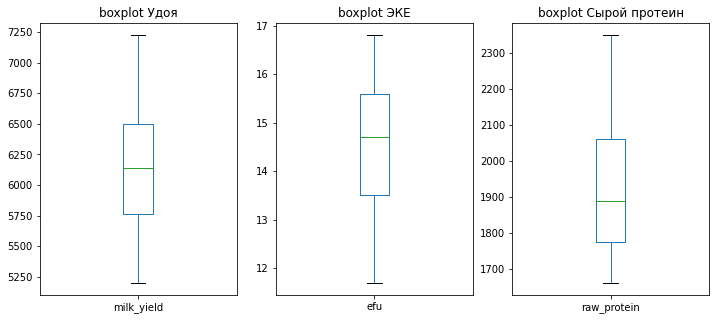

In [49]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,5))
df_main['milk_yield'].plot(kind='box', ax=axes[0])
axes[0].set_title('boxplot Удоя')
df_main['efu'].plot(kind='box', ax=axes[1])
axes[1].set_title('boxplot ЭКЕ')
df_main['raw_protein'].plot(kind='box', ax=axes[2])
axes[2].set_title('boxplot Сырой протеин')
plt.show()

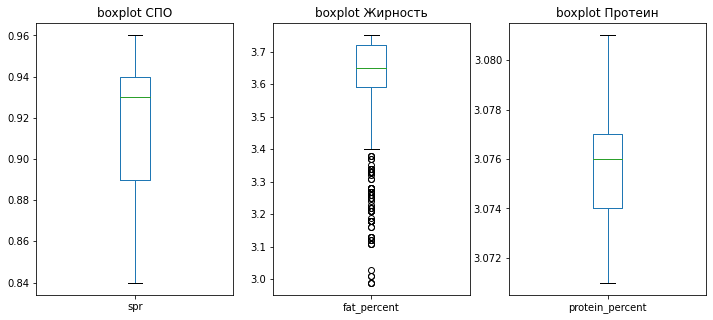

In [50]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,5))
df_main['spr'].plot(kind='box', ax=axes[0])
axes[0].set_title('boxplot СПО')
df_main['fat_percent'].plot(kind='box', ax=axes[1])
axes[1].set_title('boxplot Жирность')
df_main['protein_percent'].plot(kind='box', ax=axes[2])
axes[2].set_title('boxplot Протеин')
plt.show()

**Вывод по числовым данным датафрейма *df_main*:**

> Избавились от аномальных значений, которые были в датафрейме

> Построили частотные гистограммы для всех числовых данных, посмотрели общуюю статистическую картину

> Построили ящики с усами, убедились, что **избавились от выбросов**

> Для значений **Жирности** было принято решение - **оставить** часть выбросов, чтобы не потерять большое количество данных

Выбросы наблюдаются только в столбце с Жирностью, но из-за их объема, было решено оставить их. Рассмотрим теперь категориальные переменные в таблице ***df_main***:

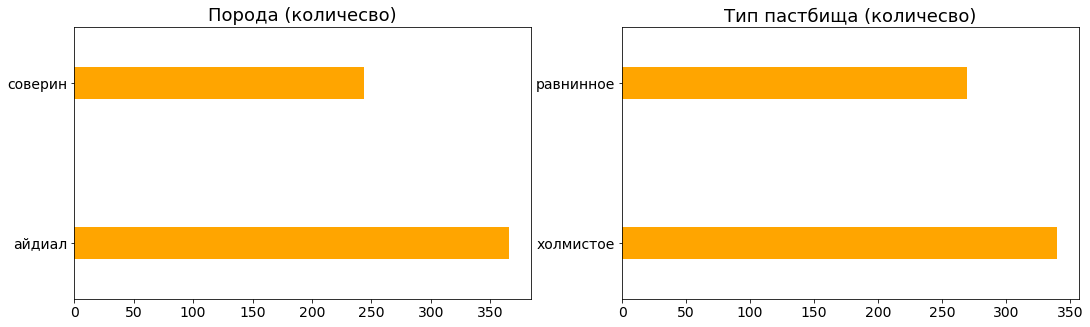

<Figure size 864x432 with 0 Axes>

In [51]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18,5))
plt.figure(figsize=(12,6))
df_main['breed'].value_counts().plot(kind='barh', width = 0.2, color='orange', fontsize=14, ax=axes[0])
axes[0].set_title('Порода (количесво)', fontsize=18)
df_main['type_pasture'].value_counts().plot(kind='barh', width = 0.2, color='orange', fontsize=14, ax=axes[1])
axes[1].set_title('Тип пастбища (количесво)', fontsize=18)
plt.show()

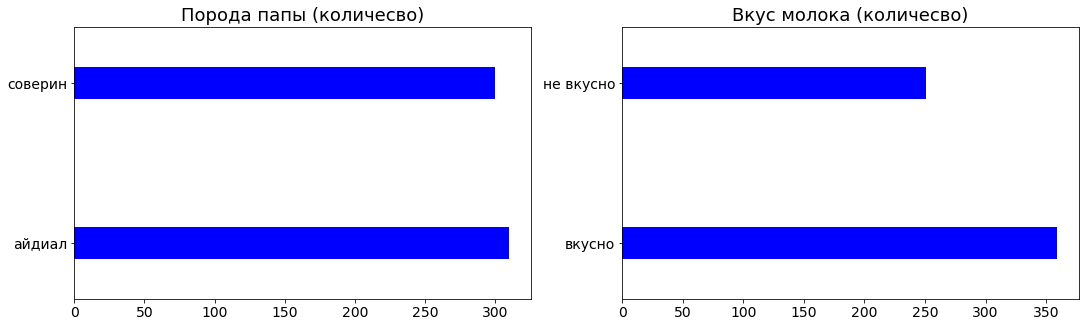

<Figure size 864x432 with 0 Axes>

In [52]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18,5))
plt.figure(figsize=(12,6))
df_main['dad_breed'].value_counts().plot(kind='barh', width = 0.2, color='blue', fontsize=14, ax=axes[0])
axes[0].set_title('Порода папы (количесво)', fontsize=18)
df_main['taste_milk'].value_counts().plot(kind='barh', width = 0.2, color='blue', fontsize=14, ax=axes[1])
axes[1].set_title('Вкус молока (количесво)', fontsize=18)
plt.show()

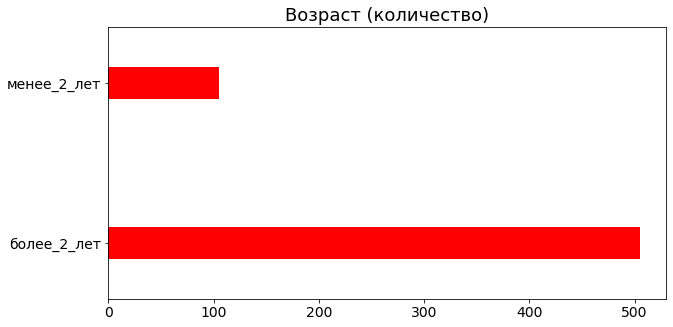

In [53]:
plt.figure(figsize=(10,5))
df_main['age'].value_counts().plot(kind='barh', width = 0.2, color='red', fontsize=14)
plt.title('Возраст (количество)', fontsize=18)
plt.show()

**Вывод по категориальным данным датафрейма *df_main*:**

> Коров породы "соверин" **меньше**, чем "айдиал"

> Холмистых пастбищ **больше**, чем равнинных

> Отцовские линии для всех коров приблизительно **равны**

> **Преобладает** вкусное молоко, в противовес не вкусному

> Большая часть коров имеет возраст **более 2 лет**

### Анализ df_dad

В ***df_dad*** хранятся только уникальные **идентификаторы** и **имена пап коров**, посмотрим какие имена встречаются чаще других:

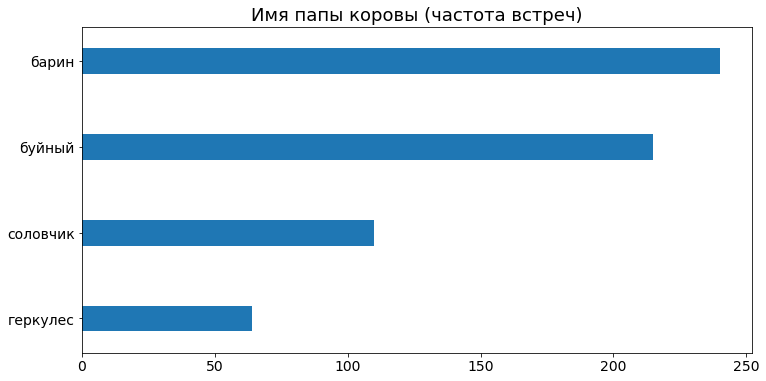

In [54]:
plt.figure(figsize=(12,6))
df_dad['name_dad'].value_counts().sort_values(ascending=True).plot(kind='barh', width=0.3, fontsize=14)
plt.title('Имя папы коровы (частота встреч)', size=18)
plt.show()

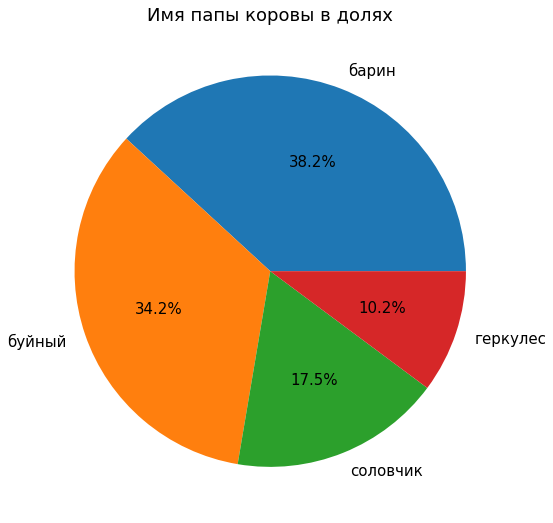

In [55]:
#На круговой диаграмме можно более наглядно увидеть доли определенных имен:
df_dad['name_dad'].value_counts().plot(kind='pie', figsize=(9,9), autopct='%1.1f%%', fontsize=15)
plt.ylabel('')
plt.title('Имя папы коровы в долях', size=18)
plt.show()

> Самое частое встречающиеся имя - ***барин***

> Самое редкое - ***геркулес***

### Анализ df_cow

Рассмотрим сначала, категориальные данные, выполним аналогичные действия, построим столбчатые гистограммы:

In [56]:
#в датафрейме с данными о покупаемых коровах - всего 16 строк:
df_cow.shape

(20, 7)

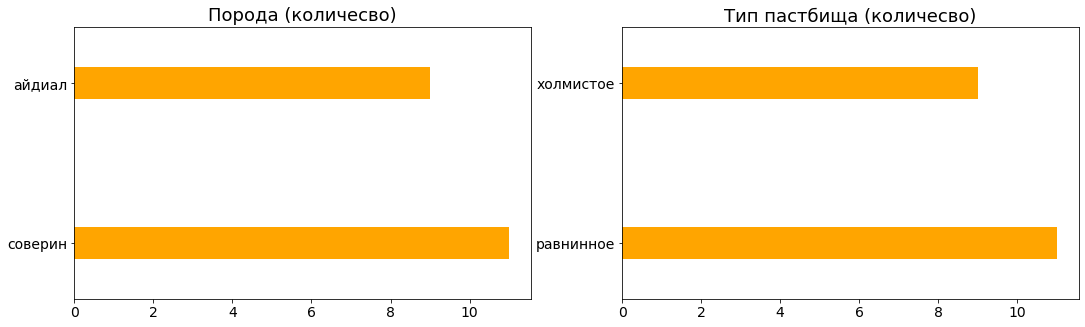

<Figure size 864x432 with 0 Axes>

In [57]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18,5))
plt.figure(figsize=(12,6))
df_cow['breed'].value_counts().plot(kind='barh', width = 0.2, color='orange', fontsize=14, ax=axes[0])
axes[0].set_title('Порода (количесво)', fontsize=18)
df_cow['type_pasture'].value_counts().plot(kind='barh', width = 0.2, color='orange', fontsize=14, ax=axes[1])
axes[1].set_title('Тип пастбища (количесво)', fontsize=18)
plt.show()

Породы продаваемых коров в одинаковом соотношении, как и пастбища, на которых они паслись

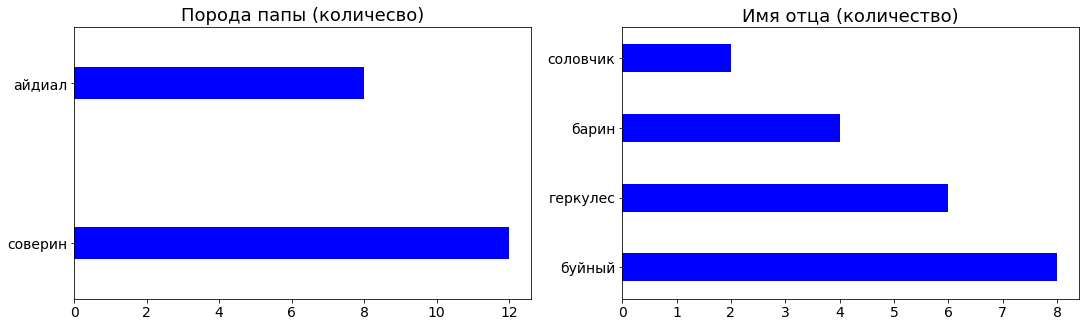

<Figure size 864x432 with 0 Axes>

In [58]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18,5))
plt.figure(figsize=(12,6))
df_cow['dad_breed'].value_counts().plot(kind='barh', width = 0.2, color='blue', fontsize=14, ax=axes[0])
axes[0].set_title('Порода папы (количесво)', fontsize=18)
df_cow['name_dad'].value_counts().plot(kind='barh', width = 0.4, color='blue', fontsize=14, ax=axes[1])
axes[1].set_title('Имя отца (количество)', fontsize=18)
plt.show()

По отцовской линии преобладают породы "соверин". Чаще всего папы имеют имя **буйный**. Посмтроим соотношение долей имен, круговой диаграммой:

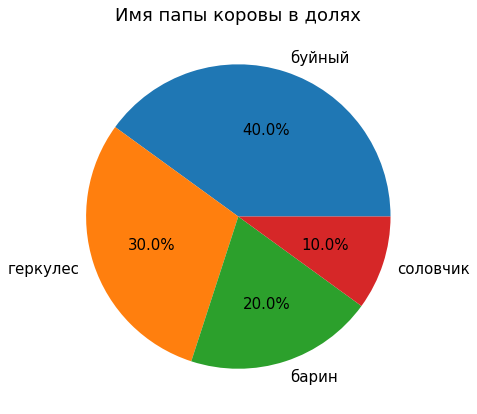

In [59]:
#На круговой диаграмме можно более наглядно увидеть доли определенных имен:
df_cow['name_dad'].value_counts().plot(kind='pie', figsize=(7,7), autopct='%1.1f%%', fontsize=15)
plt.ylabel('')
plt.title('Имя папы коровы в долях', size=18)
plt.show()

Результаты почти такие же как и в главном датафрейме ***df_main***

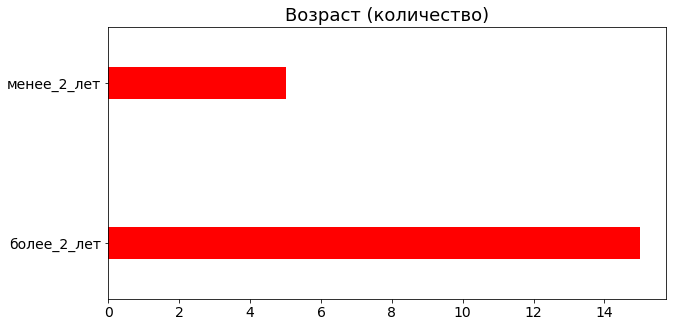

In [60]:
plt.figure(figsize=(10,5))
df_cow['age'].value_counts().plot(kind='barh', width = 0.2, color='red', fontsize=14)
plt.title('Возраст (количество)', fontsize=18)
plt.show()

Треть коров от общего числа, выставленных на продажу, младше двух лет, остальные - старше.

Рассмотрим теперь числовые признаки таблицы ***df_cow***:

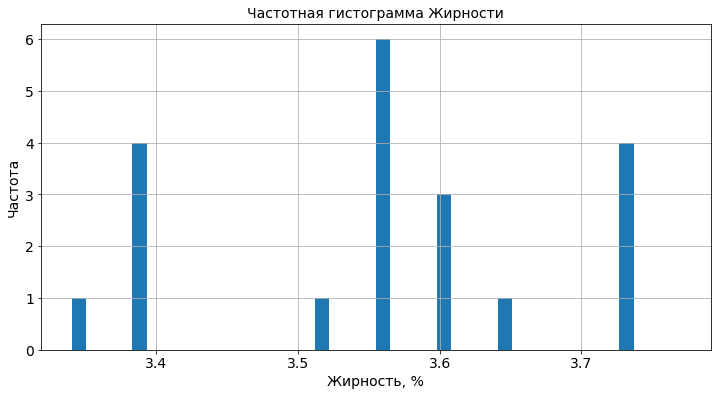

In [61]:
plt.figure(figsize=(12,6))
df_cow['current_fat_percent'].plot(kind='hist', bins=10, width=0.01, fontsize=14, grid=True)
plt.xlabel('Жирность, %', fontsize=14)
plt.ylabel('Частота', fontsize=14)
plt.title('Частотная гистограмма Жирности', fontsize=14)
plt.show()

> Слишком маленькая выборка (20) и гистограмма частотности - дискретна. Распределение **не нормальное**

In [62]:
#Знаечние моды
df_cow['current_fat_percent'].mode()[0]

3.4

In [63]:
#данные лежат в диапозоне 3.34 - 3.77:
df_cow['current_fat_percent'].sort_values()

18    3.34
9     3.40
15    3.40
3     3.40
13    3.42
1     3.54
7     3.57
0     3.58
6     3.58
8     3.59
14    3.59
2     3.59
5     3.63
4     3.64
19    3.64
12    3.68
10    3.73
11    3.73
16    3.73
17    3.77
Name: current_fat_percent, dtype: float64

Значений маленькое количество и они лежат в нормальном диапозоне, поэтого говорить о выбрасах данных - **не стоит**. Построим теперь гистрограмму для Белков


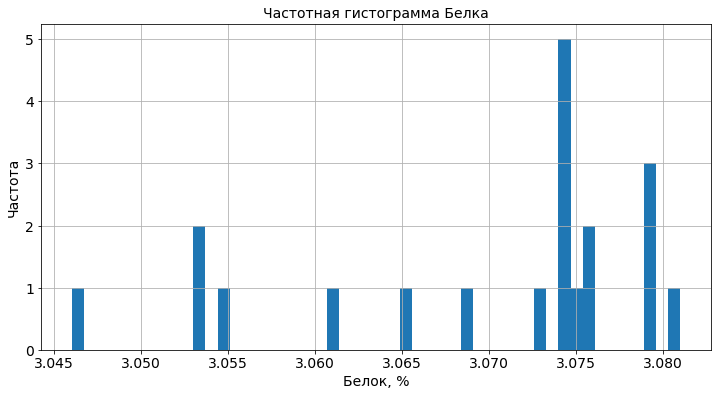

In [64]:
plt.figure(figsize=(12,6))
df_cow['current_protein_percent'].plot(kind='hist', bins=50, fontsize=14, grid=True)
plt.xlabel('Белок, %', fontsize=14)
plt.ylabel('Частота', fontsize=14)
plt.title('Частотная гистограмма Белка', fontsize=14)
plt.show()

> Гистограмма частотности - дискретна. Распределение **не нормальное**

In [65]:
#Знаечние моды
df_cow['current_protein_percent'].mode()[0]

3.074

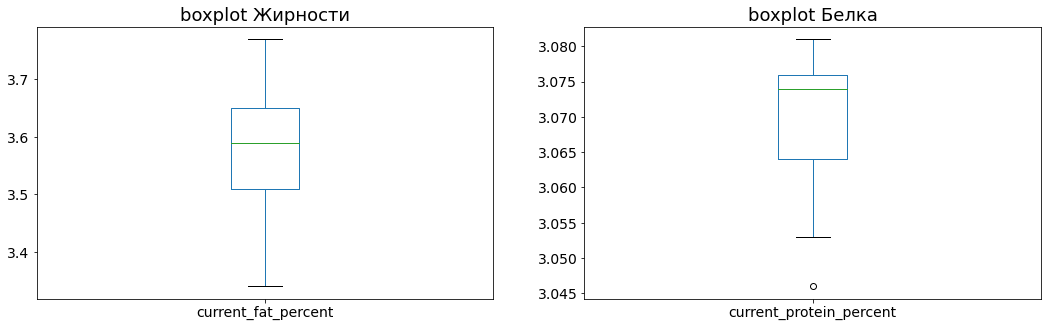

In [66]:
#Убедимся, что в данных нет выбросов, построим boxplot'ы:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18,5))
df_cow['current_fat_percent'].plot(kind='box', fontsize=14, ax=axes[0])
axes[0].set_title('boxplot Жирности', fontsize=18)
df_cow['current_protein_percent'].plot(kind='box', fontsize=14, ax=axes[1])
axes[1].set_title('boxplot Белка', fontsize=18)
plt.show()

Как видно из простроенных графиков, в числовых данных выбросов не наблюдается

### Сводка

In [67]:
#Вызовем снова функцию check и посмотрим на процент удаленных данных:
check(df_main, df_dad, df_cow)

Количество удаленных строк: 24
Процент потерянных данных от общего числа: 1.87%


С удаленными аномальными значениями, процент потерянных данных от изначального составил: **1.87%**

**Вывод по исследовательскому анализу**

> Выбросы и аномальные значения были выявлены только в датафрейме ***df_main***, после удалены из него

> Для всех числовых данных построены Boxplot графики, по которым можно наблюдать наличие выбросов

> Для всех категориальных данных приведены столбчатые графики и круговые диаграммы, для удобства **сравнения** их количества

<a id='section_4'></a>

## Корреляционный анализ

### Матрица корреляции по Phik

In [68]:
# Построим матрицу корреляций по всем числовым и категориальным признакам с помощью библиотеки phik:
df_main.drop('id', axis=1).phik_matrix()

interval columns not set, guessing: ['milk_yield', 'efu', 'raw_protein', 'spr', 'fat_percent', 'protein_percent']


milk_yield       efu  raw_protein       spr     breed  \
milk_yield         1.000000  0.725037     0.467927  0.662453  0.160581   
efu                0.725037  1.000000     0.446533  0.590988  0.062426   
raw_protein        0.467927  0.446533     1.000000  0.386248  0.091894   
spr                0.662453  0.590988     0.386248  1.000000  0.052519   
breed              0.160581  0.062426     0.091894  0.052519  1.000000   
type_pasture       0.287978  0.121902     0.075627  0.131013  0.216902   
dad_breed          0.515874  0.197398     0.000000  0.414101  0.077006   
fat_percent        0.705698  0.713885     0.400280  0.640636  0.215906   
protein_percent    0.223438  0.000000     0.234318  0.000000  0.343740   
taste_milk         0.171357  0.298872     0.174942  0.567940  0.000000   
age                0.997928  0.764551     0.353792  0.747759  0.064404   

                 type_pasture  dad_breed  fat_percent  protein_percent  \
milk_yield           0.287978   0.515874     0.705698         0.223438   
efu                  0.121902   0.197398     0.713885         0.000000   
raw_protein          0.075627   0.000000     0.400280         0.234318   
spr                  0.131013   0.414101     0.640636         0.000000   
breed                0.216902   0.077006     0.215906         0.343740   
type_pasture         1.000000   0.000000     0.000000         0.177461   
dad_breed            0.000000   1.000000     0.000000         0.097097   
fat_percent          0.000000   0.000000     1.000000         0.000000   
protein_percent      0.177461   0.097097     0.000000         1.000000   
taste_milk           0.267696   0.000000     0.207951         0.108064   
age                  0.121903   0.340426     0.674584         0.000000   

                 taste_milk       age  
milk_yield         0.171357  0.997928  
efu                0.298872  0.764551  
raw_protein        0.174942  0.353792  
spr                0.567940  0.747759  
breed              0.000000  0.064404  
type_pasture       0.267696  0.121903  
dad_breed          0.000000  0.340426  
fat_percent        0.207951  0.674584  
protein_percent    0.108064  0.000000  
taste_milk         1.000000  0.157594  
age                0.157594  1.000000

interval columns not set, guessing: ['milk_yield', 'efu', 'raw_protein', 'spr', 'fat_percent', 'protein_percent']


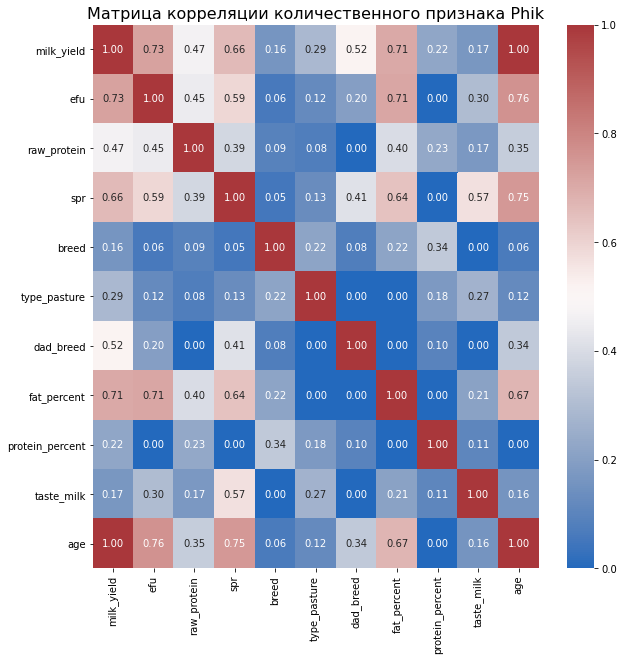

In [69]:
#визуализируем матрицу с помощью тепловой карты, для удобства:
plt.figure(figsize=(10,10))
sns.heatmap(df_main.drop('id', axis=1).phik_matrix(), annot=True, fmt='.2f', cmap='vlag')
plt.title('Матрица корреляции количественного признака Phik', fontsize=16)
plt.show()

**Удой** имеет высокую корреляцию:

> **ЭКЕ** - 0.73

> **СПО** - 0.66

> **Жирность** - 0.71

### Матрица корреляции по Спирмену

Коэффициент корреляции Спирмена (Spearman rank correlation coefficient) — мера линейной связи между случайными величинами. Корреляция Спирмена является ранговой, то есть для оценки силы связи используются не численные значения, **а соответствующие им ранги**. Коэффициент инвариантен по отношению к любому монотонному преобразованию шкалы измерения.

Т.к. коэф.корреляции Спирмена применятся только к ранжированным данным, которые могут быть представленные как категориальные переменные, применим его и посмотрим на наличие взаимосвязи между всеми категориальными переменными:

In [70]:
#создадим список в который сохраним имена столбцов в которых значения - категориальные переменные:
categories = []

for i in df_main.columns:
    if type(df_main[i].values[0]) == str:
        categories.append(i)
print(categories)

['breed', 'type_pasture', 'dad_breed', 'taste_milk', 'age']


In [71]:
#Построим матрицу корреляций по значению коэффициента 
a = []

#Перебераем категориальные переменные:
for i in categories:
    for j in categories:
        #выберем значения корреляции с помощью spearmanr:
        a.append(spearmanr(df_main[i], df_main[j])[0])      

pd.concat([pd.Series(a[:5]), pd.Series(a[5:10]), pd.Series(a[10:15]), pd.Series(a[15:20]), pd.Series(a[20:25])], axis=1)

/opt/conda/lib/python3.9/site-packages/scipy/stats/_stats_py.py:110: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  warnings.warn("The input array could not be properly "


0         1         2         3         4
0  1.000000  0.148216  0.066935 -0.016320 -0.062051
1  0.148216  1.000000  0.011797 -0.180428 -0.092018
2  0.066935  0.011797  1.000000 -0.002949  0.228984
3 -0.016320 -0.180428 -0.002949  1.000000  0.112914
4 -0.062051 -0.092018  0.228984  0.112914  1.000000

Как видно из матрицы корреляции Спирмена, сильной взаимосвязи между категориальными переменными - **нет**

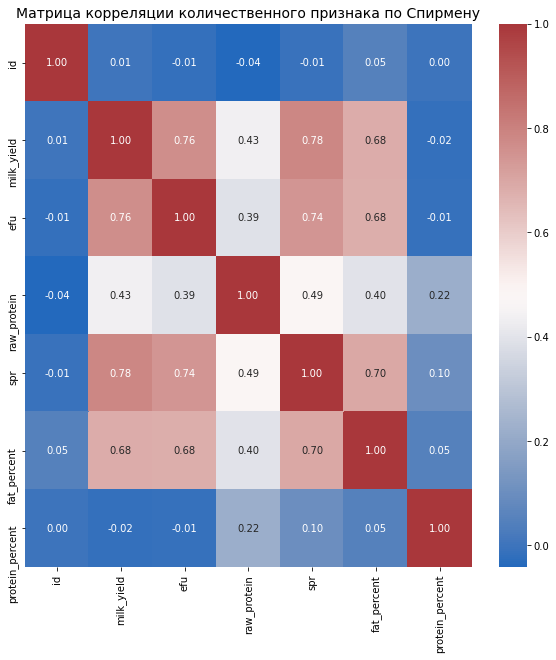

In [72]:
#визуализируем матрицу с помощью тепловой карты, для удобства:
plt.figure(figsize=(10,10))
sns.heatmap(df_main.corr(method='spearman'), annot=True, fmt='.2f', cmap='vlag')
plt.title('Матрица корреляции количественного признака по Спирмену', fontsize=14)
plt.show()

Большая корреляция с целевым признаком ***milk_yield*** (Удой):

- у признака ЭКЕ (энергетической кормовой единицы) - составляет **0.76**

- у признка СПО (Сахарно-протеиновое соотношение) - составляет **0.78**

Средняя корреляция с целевым признаком:

- у признака Жирность, % - составляет **0.68**

### Диаграммы рассеяния

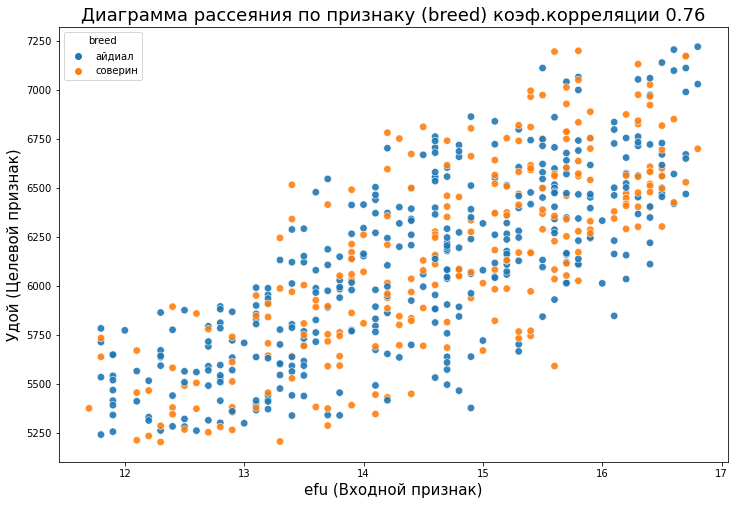

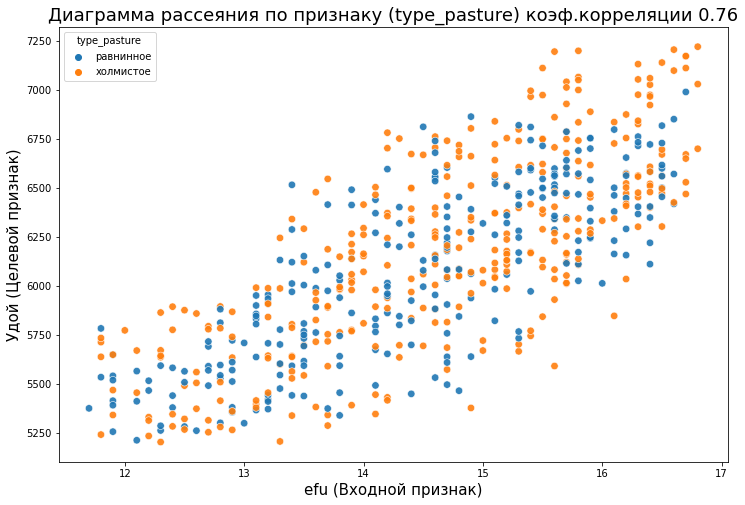

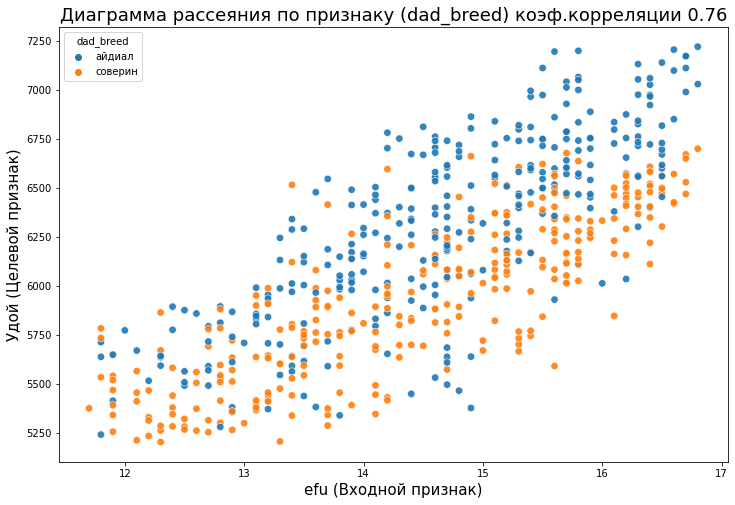

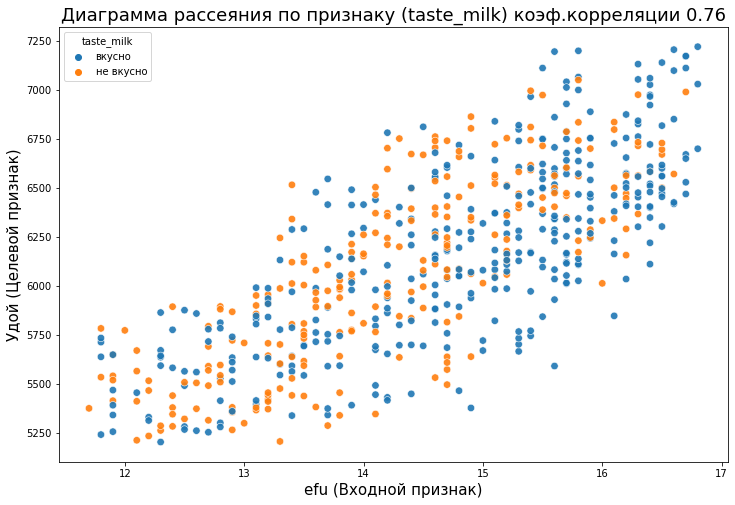

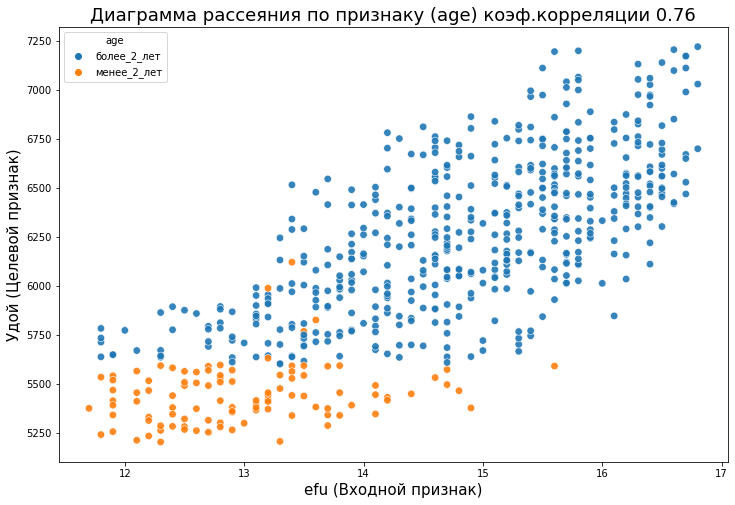

In [73]:
#Создадим функцию, которая будет принимать целевой параметр и описательные
#а также выводить графики корреляции в зависимости от категориальной переменной:
def plotting_scatter(x1, y1):
    #Будем строить графики корреляции перебирая категориальные переменные:
    for i in categories:
        #Вывод коэффициента коррелирующих величин:
        k = df_main[x1].corr(df_main[y1], method='spearman')
        #Построение диаграмм рассеяния:
        plt.figure(figsize=(12,8))
        sns.scatterplot(data=df_main, x=x1,  y=y1, s=55, alpha=0.9, hue=df_main[i])
        plt.xlabel(f'{x1} (Входной признак)', fontsize=15)
        plt.ylabel('Удой (Целевой признак)', fontsize=15)
        plt.title(f'Диаграмма рассеяния по признаку ({i}) коэф.корреляции {k:.2f}', fontsize=18)
        plt.show()
        print()

#Вызовем функцию для целевой переменной, и входного признака ЭКЕ:
plotting_scatter('efu', 'milk_yield')

Итак, мы посмотрели корреляцию **целевого параметра** (Удоя) и **ЭКЕ** в зависимости от различных категориальных данных. Теперь можем сделать выводы по построенным графикам:

> Зависимость между ЭКЕ и Удоем - по графику она похожа на **линейную** и частично имеет **степенную** зависимость, можно заметить **ветвь параболы**

> В зависимоти от **породы**, **типа пастбища** и **вкуса молока** - все значения распределяются равномерно по всей плотности диаграммы рассеяния, т.е. выделить определенные группы (разделить) - тяжело

> По признаку **породы отца** можно заметить, что значения группы **айдиалс** нависают над **соверинг**, судя по диаграмме рассеяния - у первого типа (айдиалс) **больше общий удой** за год, чем у соверинг

> По признаку **возраст** можно сказать, что коровы, которые старше двух лет - приносят в среднем больше молока за год

Рассмотрим теперь корреляцию для целевого признака и **сырого протеина**, также в зависимости от групп:

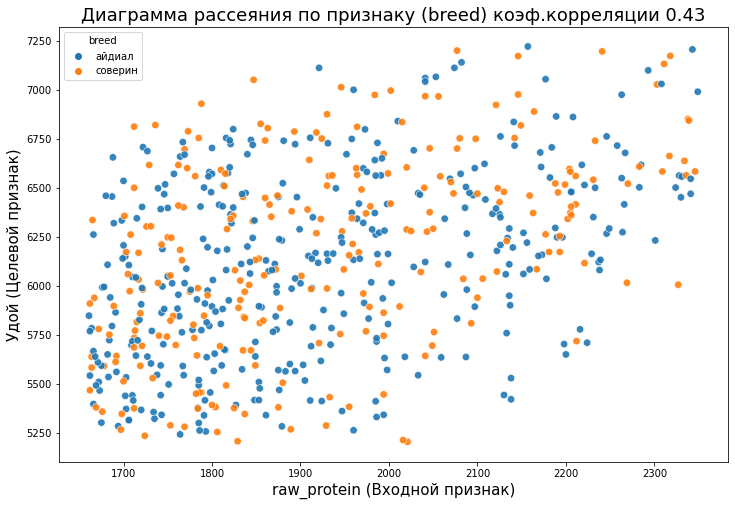

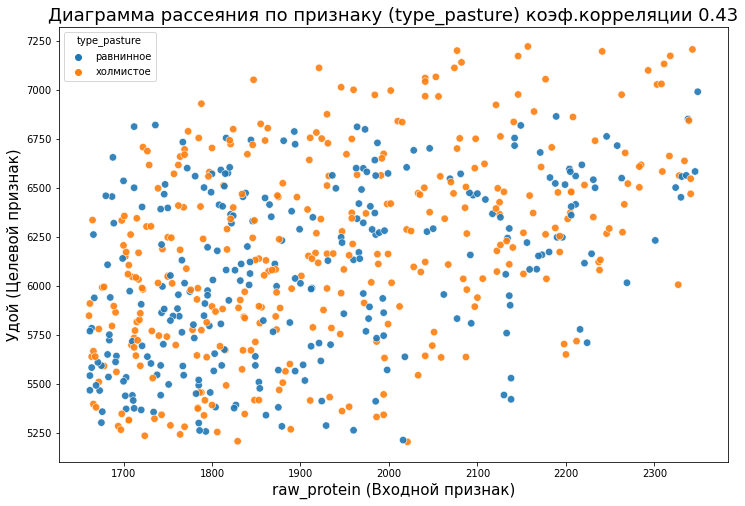

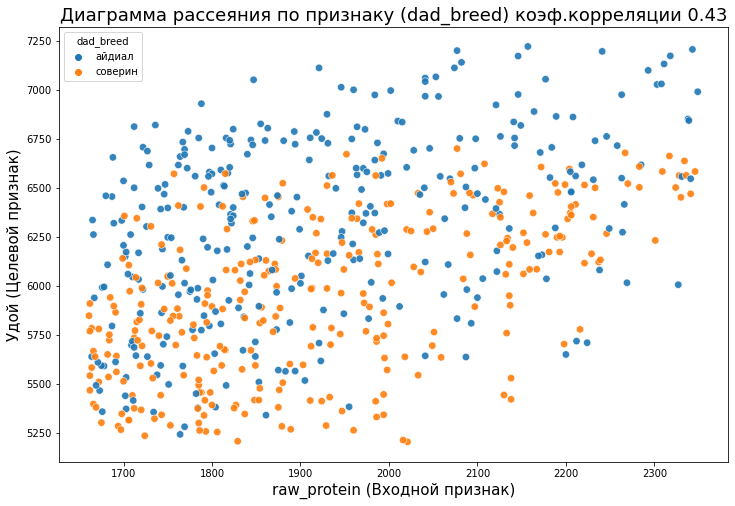

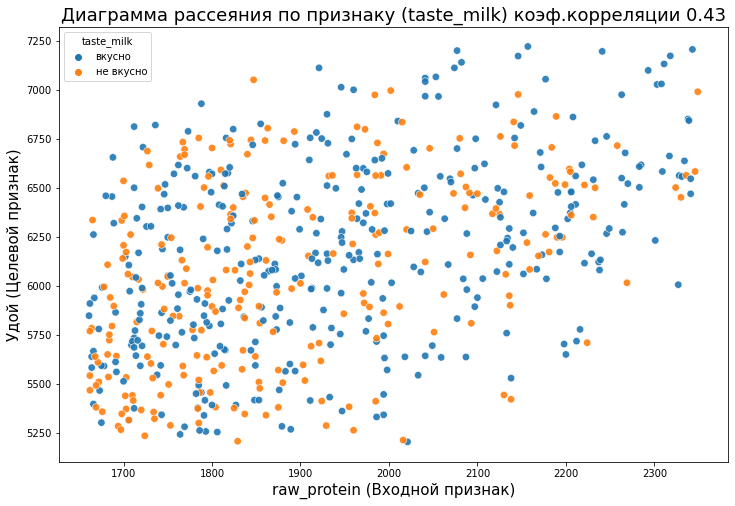

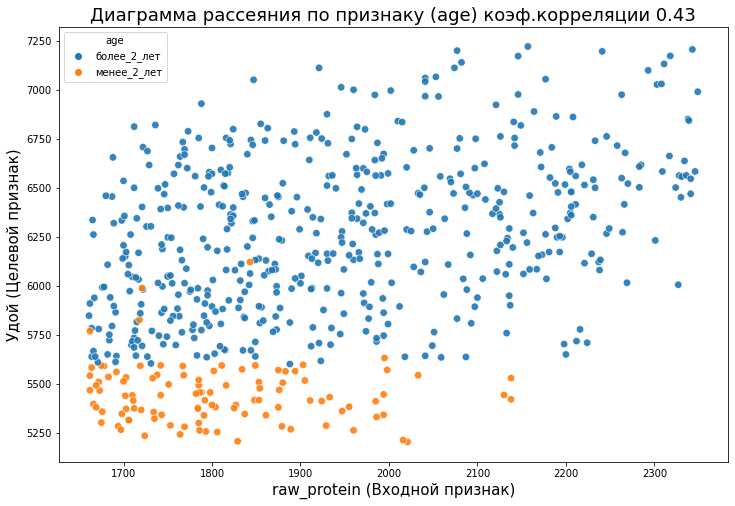

In [74]:
#Вызовем функцию, передав ей параметры целевого признака и входного (сырой протеин):
plotting_scatter('raw_protein', 'milk_yield')

> Линейная зависимость по графику между Удоем и сырым протеином - не прослеживается, возможно видоизменяя масштаб, зависимость будет видна лучше

> Как видно из диаграмм рассеяния, значения разбросаны сильней, общая структура наблюдается **хуже**, коэфф.корреляции **0.43**

> Почти во всех графиках сложно выделить определенные группы - значения **смешаны**

> Только по категориальному признаку **возраст** группы делятся наглядно. Коровы имеющие возраст более двух лет, имеют больший удой и сырой протеин (в граммах) у них либо такой же, либо выше

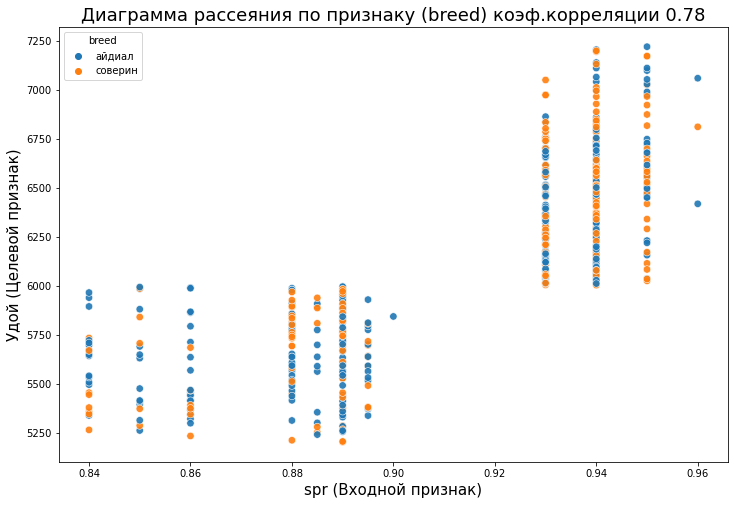

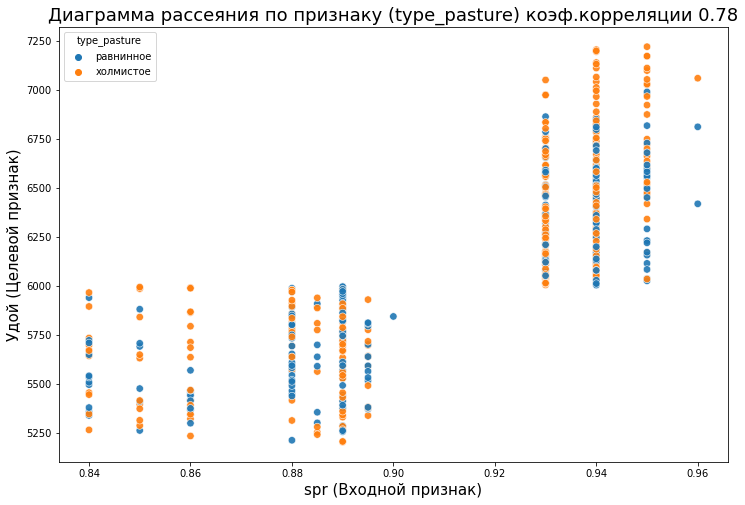

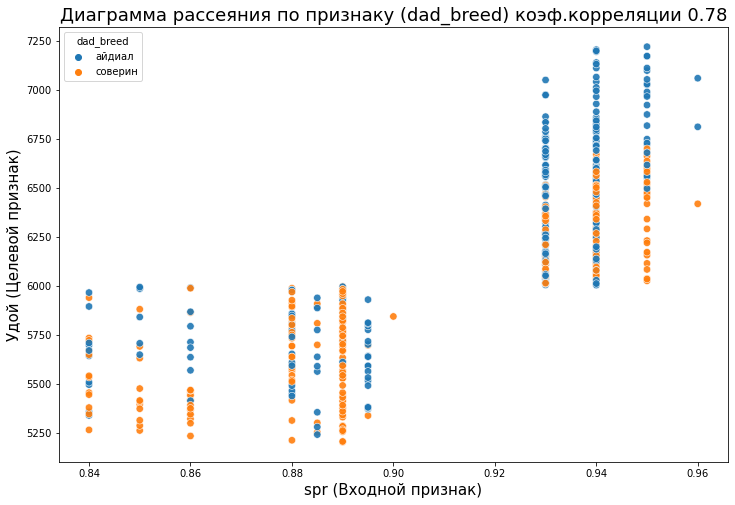

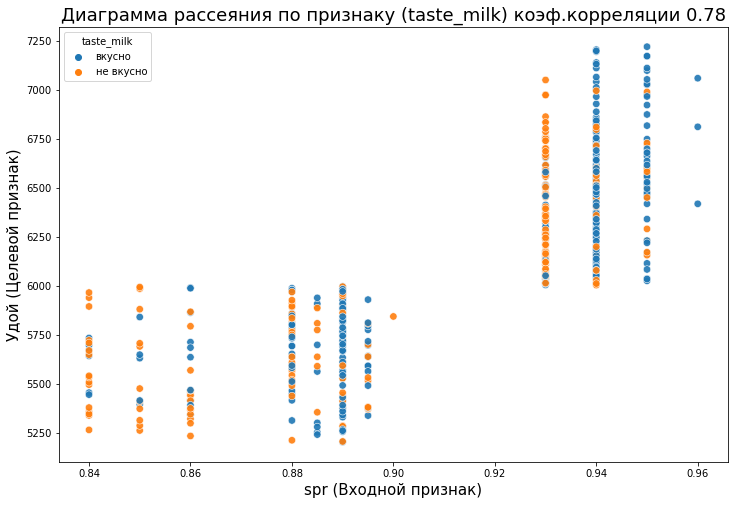

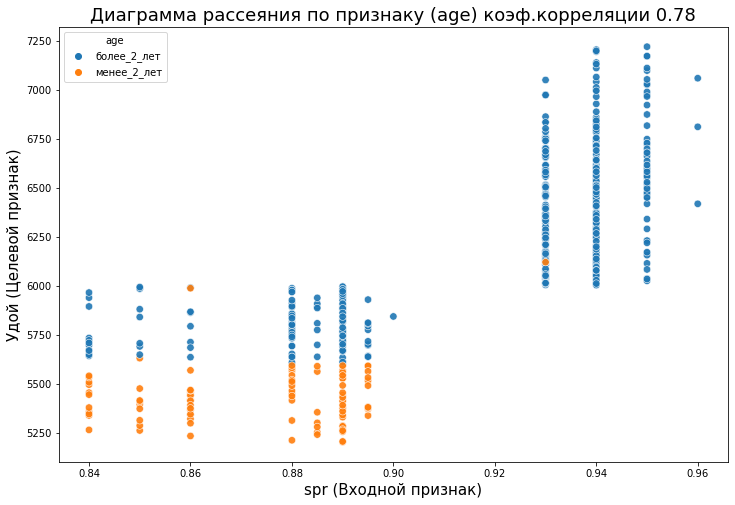

In [75]:
#Вызовем функцию, передав ей параметры целевого признака и входного (Сахарно-протеиновое соотношение):
plotting_scatter('spr', 'milk_yield')

Такие графики корреляции, говорят о том, что значения одного из параметров - **дискретны**, в нашем случае это параметр **SPR**.
С такими данными тоже можно работать и получать необходимую информацию.

> Говорить о линейной зависимости между Удоем и СПО - трудно, из-за дискретности значений группы разделены на кластеры

> Наивысший показатель удоя, дают коровы, которые паслись на пастбище типа **"холмистое"**

> Наивысший показатель удоя, дают коровы, папа которых имел породу **айдиал**

> **Не вкусное** молоко, в большенстве случаев, лежит в интервалах СПО - от 0.84~0.86, а так же с соотношением 0.93

> **Вкусное** молоко, в большей степени лежит в интервале от 0.94 и выше, по СПО

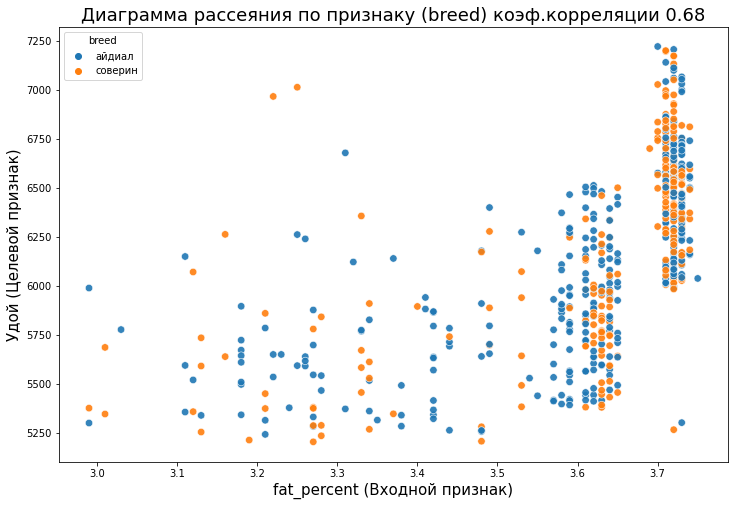

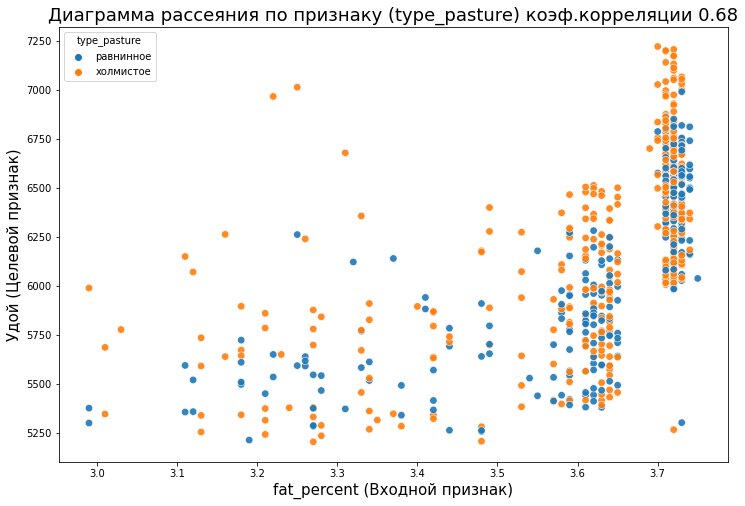

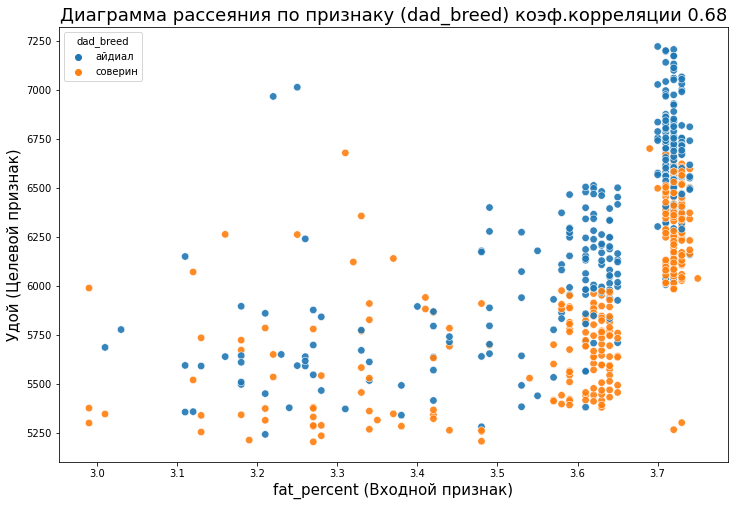

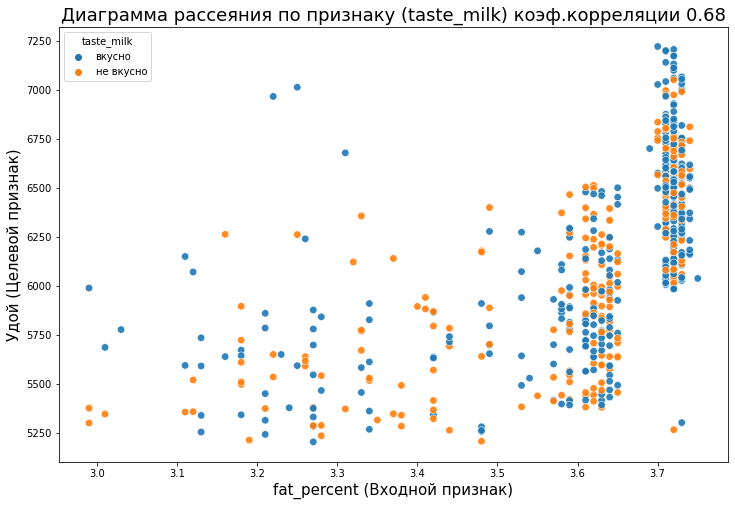

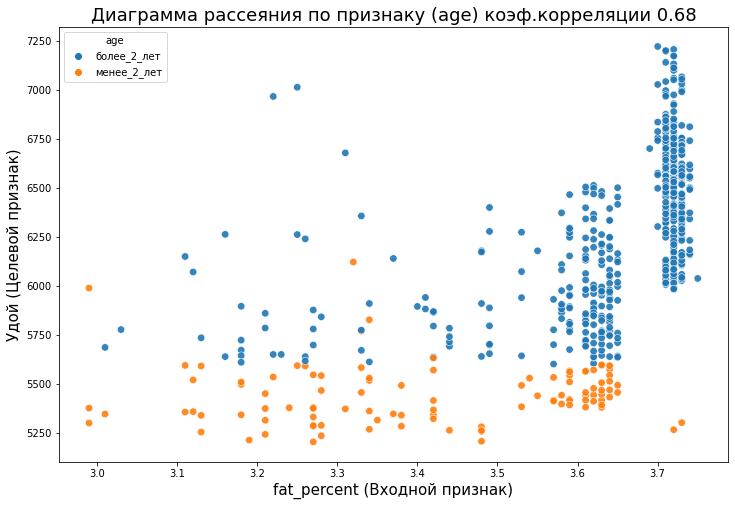

In [76]:
#Вызовем функцию, передав ей параметры целевого признака и входного (Жирность %):
plotting_scatter('fat_percent', 'milk_yield')

Из диаграмм рассеяния видно, что большая часть значений приходиться на **процент жирности** свыше 3.5%

> Линейная зависимость также как и в предыдущих случаях наблюдается - плохо. 

> Из диаграммы рассеяния по признаку возраста можно сделать вывод, что коровы младше двух лет почти не дают процент жирности равный и выше 3.7%

> В остальных диаграммах выводы совподают с сделанными ранее

In [77]:
#Корреляцию по признаку процент белков:
df_main['milk_yield'].corr(df_main['protein_percent'], method='spearman')

-0.01566128742332243

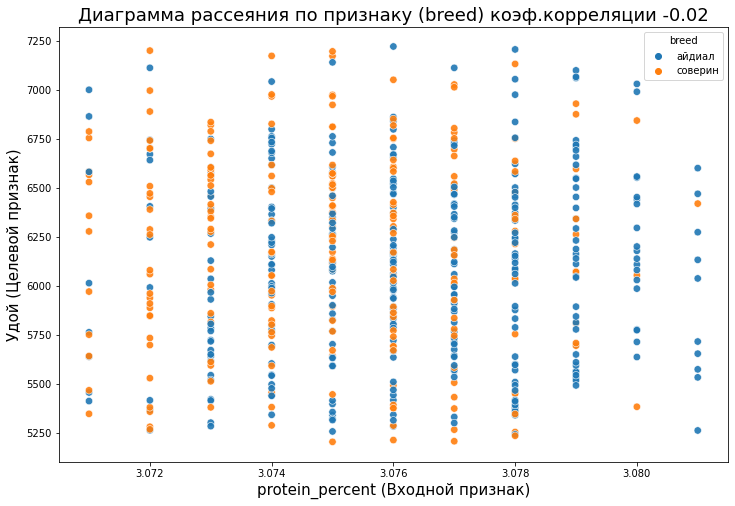

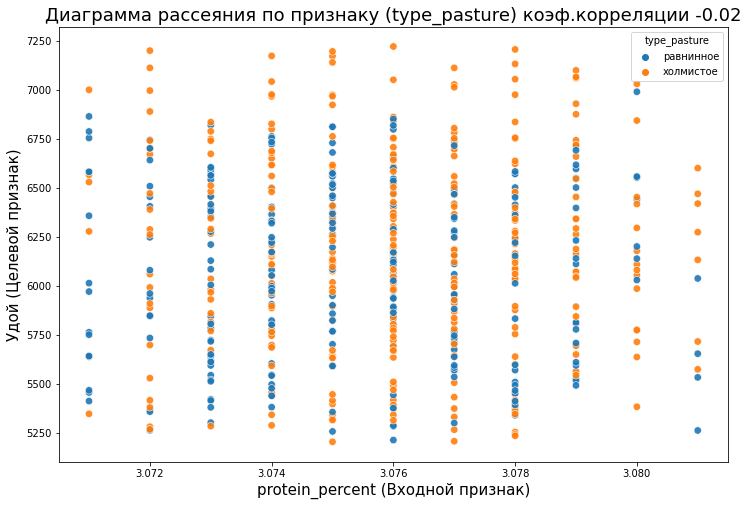

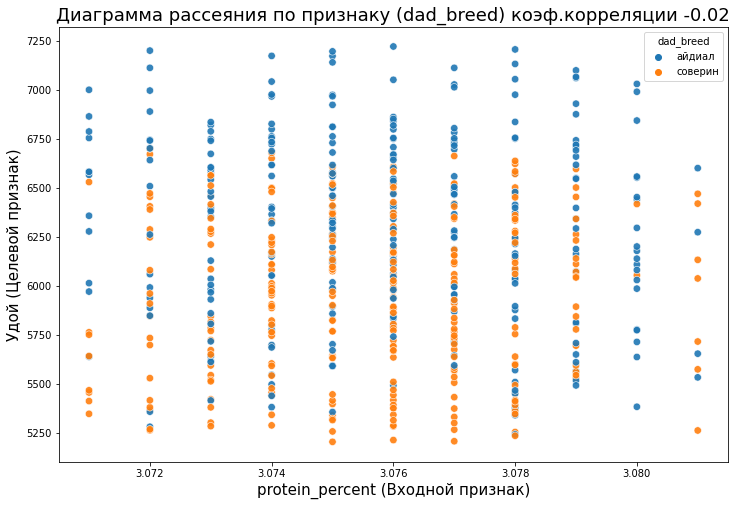

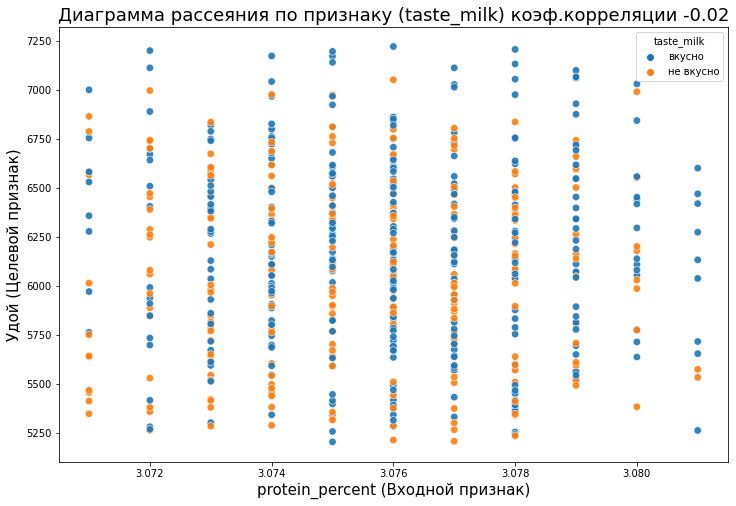

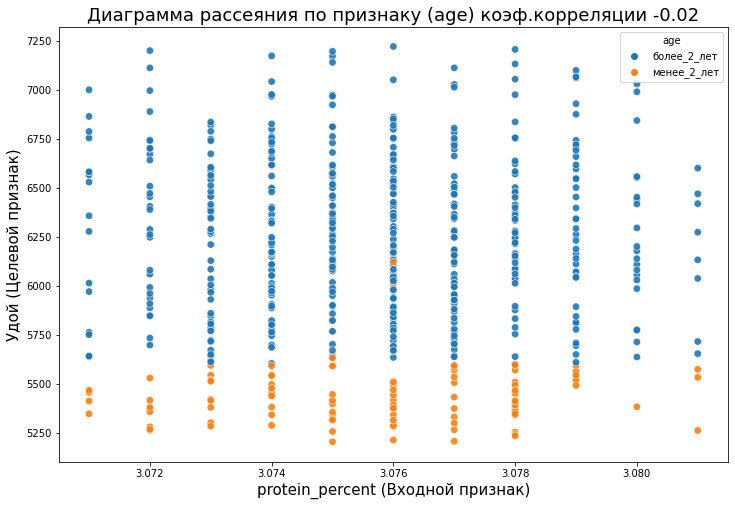

In [78]:
plotting_scatter('protein_percent', 'milk_yield')

Из диаграмм рассеяния видно, что все знаечния плотно распределены по всей области построения графика, а также дискретны, даже по количественному соотношению взаимосвязей можно сказать, что данные распределенны в похожих пропорциях

> Линейная зависимость наблюдается - плохо. 

> Количество зависимостей на каждую дискретную величину равномерно распределены 

> В остальных диаграммах выводы совподают с сделанными ранее

### Анализ результатов корреляции

- **по шкале Чеддока** значение линейного коэффициента корреляции: 

> 0.7 - 0.9 - **высокая**

> 0.5 - 0.7 - **заметная**

> 0.3 - 0.5 - **умеренная**

У нас есть три вида корреляции входных (числовых) признаков с целевой переменной:

> **Высокая корреляция** - наблюдается между целевой переменной и признаками: **ЭКЕ ~ 0.73** (энергетическая кормовая единица), **СПО ~ 0.66** (сахарно-протеиновое соотношение)

> **Заметная корреляция** - наблюдается между целевой переменной и признаком: **Жирность ~ 0.71** 

> **Умеренная корреляция** - наблюдается между целевой переменной и признаком: **Сырой протеин ~ 0.47** 

- **С учетом категориальных переменных** следует обратить внимание, что данные на диаграммах рассеяния - могут **группироваться**, вследсвии чего, **линейная зависимость - нарушается**

- Параметр **Возраст** для всех графиков корреляции - делит данные на группы

- **Мультиколлинеарность**, исходя из тепловой карты, **не наблюдается** между признаками, наивысшие показатели:

> **ЭКЕ и СПО** состовляет : **0.59**

> **ЭКЕ и Жирность** состовляет : **0.71**

> **СПО и Жирность** состовляет : **0.64**

- Проверили корреляцию между категориальными переменными с помощью матрицы Спирмена - сильной зависимости **не найдено**

<a id='section_5'></a>

## Обучение модели линейной регрессии

### Модель №1

Итак, рассмотрим данные, которые можно использовать в качестве входных признаков для модели:

1. Характеристики молока не влияют на удой, в отличие от параметров корма. Поэтому исключаем из модели такие признаки как: **fat_percent**, **protein_percent** и **taste_milk** - числовые и описательные характеристики молока

2. Также следует исключить **id** - это признак, который не влияет на удой

3. В таблице имеются коррелирующие между собой входные признаки но **мультиколлинеарность** не наблюдается, показателя свыше 0.9 нет ни у одной пары входных признаков. Оставим СПО и ЭКЕ т.к. в параметре Жирность - **имееются выбросы**, не будет торопиться с добовлением его в признаки модели

Получается, при расчёте модели мы искючаем четыре признака, указанных выше

In [79]:
#Сохраним копию исходного датафрейма:
df_model_1 = df_main

In [80]:
#Удалим из копии ненужные входные признаки:
df_model_1 = df_model_1.drop(['id', 'fat_percent', 'protein_percent', 'taste_milk'], axis=1)

In [81]:
#Выведем получившийся датафрейм:
df_model_1.head(5)

milk_yield   efu  raw_protein    spr    breed type_pasture dad_breed  \
0        5863  14.2         1743  0.890   айдиал    равнинное    айдиал   
1        5529  12.8         2138  0.890   айдиал    равнинное   соверин   
2        5810  14.0         1854  0.885  соверин    холмистое   соверин   
3        5895  12.4         2012  0.885  соверин    холмистое    айдиал   
4        5302  12.8         1675  0.885   айдиал    равнинное   соверин   

           age  
0  более_2_лет  
1  менее_2_лет  
2  более_2_лет  
3  более_2_лет  
4  менее_2_лет

In [82]:
#Создаем модель №1:

#Задаем константу:
RANDOM_STATE = 42

#Отделяем целой признак и входные

#Входные признаки:
X = df_model_1.drop('milk_yield', axis=1)
#Целевой признак:
y = df_model_1['milk_yield']

X_train, X_test, y_train, y_test_m1 = train_test_split(X, y, random_state = RANDOM_STATE)

#Выполняем проверку на получившиеся размерности:
print(f'Размернорсть исходного дф: {df_model_1.shape}')
print(f'Обучающая выборка размер: {X_train.shape}')
print(f'Тестовая выборка размер: {X_test.shape}')
print(f'Cравнение {X_train.shape[0]} + {X_test.shape[0]} = {X_train.shape[0] + X_test.shape[0]}')

Размернорсть исходного дф: (610, 8)
Обучающая выборка размер: (457, 7)
Тестовая выборка размер: (153, 7)
Cравнение 457 + 153 = 610


In [83]:
#Масштабируем и кодируем данные:

#Закодируем категориальные переменные с помощью класса OneHotEncoder(): 
encoder  = OneHotEncoder(drop='first', sparse=False)

#Масштабирование данных проведем с помощью StandardScaler(), сохраним его в переменную:
scaler = StandardScaler()

#Список всех категориальных переменных и список количественных:
cat_names = ['breed', 'type_pasture', 'dad_breed', 'age']
num_names = ['efu', 'raw_protein', 'spr']

#Обучим и трансформируем данные тренеровочной выборки:
X_train_scaled = scaler.fit_transform(X_train[num_names])

#Трансформируем тестовую выборку:
X_test_scaled = scaler.transform(X_test[num_names])                                     

#Обучим и трансформируем данные тренеровочной выборки:
X_train_ohe = encoder.fit_transform(X_train[cat_names])

#Трансформируем тестовую выборку:
X_test_ohe = encoder.transform(X_test[cat_names])

#Сохраним новые имена столбцов в переменной:
encoder_col_names = encoder.get_feature_names()

#Выборки категориальных переменных, после кодирования:
X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)
 
#Выборки количественных переменных, после масштабирования:                                      
X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_names)

**Визуально просмотрим и проверим данные, которые мы масштабировали и кодировали:**

In [84]:
#Смотрим кодированные данные тренеровочной выборки:
X_train_ohe.head(5)

x0_соверин  x1_холмистое  x2_соверин  x3_менее_2_лет
0         0.0           1.0         0.0             0.0
1         1.0           1.0         0.0             0.0
2         0.0           0.0         1.0             0.0
3         1.0           1.0         1.0             0.0
4         1.0           0.0         1.0             0.0

In [85]:
#Смотрим кодированные данные тестовой выборки:
X_test_ohe.head(5)

x0_соверин  x1_холмистое  x2_соверин  x3_менее_2_лет
0         0.0           1.0         0.0             0.0
1         0.0           0.0         0.0             0.0
2         1.0           1.0         0.0             0.0
3         0.0           1.0         0.0             0.0
4         1.0           0.0         1.0             0.0

In [86]:
#Смотрим масштабированные данные тренеровочной выборки:
X_train_scaled.head(5)

efu  raw_protein       spr
0  1.277480     1.395124  0.519187
1  1.048506     1.319095  0.825340
2 -2.080812    -1.396241 -0.705425
3  0.972181     2.242309  1.131494
4 -0.783290    -1.086693 -1.011578

In [87]:
#Смотрим масштабированные данные тестовой выборки:
X_test_scaled.head(5)

efu  raw_protein       spr
0  0.285258    -0.711977  0.519187
1  0.666882    -0.418720  0.825340
2 -0.859615     0.651122 -0.552348
3 -0.096366     1.085576  0.519187
4 -0.249016     1.536322  1.131494

Данные верно были предобработаны с помощью кодирования и мастштабирования значений, теперь объединим их в один ДФ:

In [88]:
#Итоговые преобразованные тренеровочная и тестовая выборки:                                      
X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

In [89]:
#Итоговая тренеровочная выборка:
X_train.head(5)

x0_соверин  x1_холмистое  x2_соверин  x3_менее_2_лет       efu  \
0         0.0           1.0         0.0             0.0  1.277480   
1         1.0           1.0         0.0             0.0  1.048506   
2         0.0           0.0         1.0             0.0 -2.080812   
3         1.0           1.0         1.0             0.0  0.972181   
4         1.0           0.0         1.0             0.0 -0.783290   

   raw_protein       spr  
0     1.395124  0.519187  
1     1.319095  0.825340  
2    -1.396241 -0.705425  
3     2.242309  1.131494  
4    -1.086693 -1.011578

In [90]:
#Итоговая тестовая выборка:
X_test.head(5)

x0_соверин  x1_холмистое  x2_соверин  x3_менее_2_лет       efu  \
0         0.0           1.0         0.0             0.0  0.285258   
1         0.0           0.0         0.0             0.0  0.666882   
2         1.0           1.0         0.0             0.0 -0.859615   
3         0.0           1.0         0.0             0.0 -0.096366   
4         1.0           0.0         1.0             0.0 -0.249016   

   raw_protein       spr  
0    -0.711977  0.519187  
1    -0.418720  0.825340  
2     0.651122 -0.552348  
3     1.085576  0.519187  
4     1.536322  1.131494

Теперь можно обучать модель и искать закономерности:

In [91]:
#Обучение модели линейной регрессии:

#Кладем модель в переменную:
model_lr = LinearRegression()

#Находим коэффициенты:
model_lr.fit(X_train, y_train)

#Предсказываем результаты на тестовой выборке:
predictions_m1 = model_lr.predict(X_test)

# рассчитайте значение коэф.детерминации R2 для линейной регрессии:
r2 = r2_score(y_test_m1, predictions_m1)

print("R2 LinearRegression =", r2)

R2 LinearRegression = 0.7854732985628423


Коэффициент детерминации показывает насколько средняя ошибка предсказания отличается от дисперсии целевого признака в процентном соотношении. Т.е. процент изменчивости, который показывает, насколько лучше предсказывает модель, по оношению к среднему целевого признака. Положительные значения R2 показывают, в скольких процентах случаев предсказание модели ближе к истине, чем среднее значение целевого признака. В нашем случае коэффициент детерменации получился **0.7854**, следовательно, в 78% случаев наша модель предсказывает лучше, нежели предсказание средним

Теперь необходимо **проанализировать остатки**:

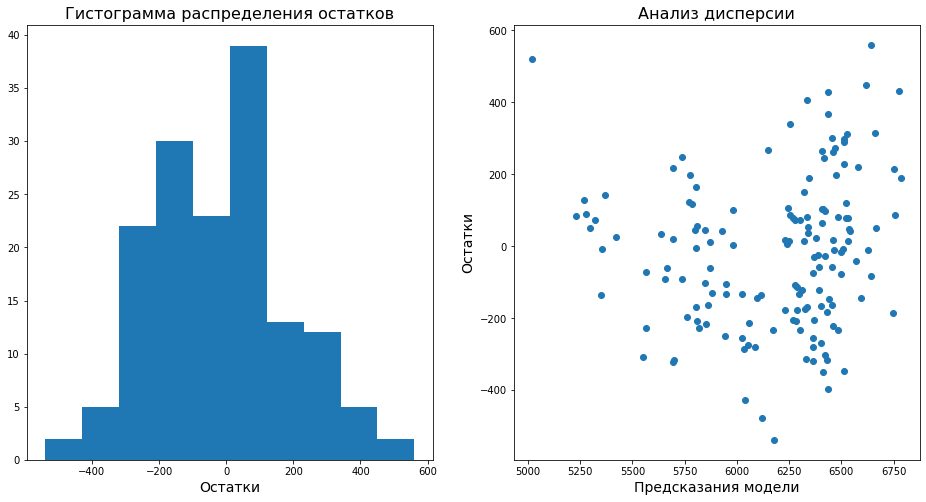

In [92]:
#Рассчитаем остатки
residuals = y_test_m1 - predictions_m1

#Построим графики по количественным признакам — гистограмму частотности распределения и диаграмму рассеяния
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,8))
axes[0].hist(residuals, bins=10)
axes[0].set_title('Гистограмма распределения остатков', fontsize=16)
axes[0].set_xlabel('Остатки', fontsize=14)

axes[1].scatter(x=predictions_m1, y=residuals)
axes[1].set_xlabel('Предсказания модели', fontsize=14)
axes[1].set_ylabel('Остатки', fontsize=14)
axes[1].set_title('Анализ дисперсии', fontsize=16)
plt.show()

**Выводы к первой модели:**

> Коэффициент детерминации равен **0.7793** - это говорит о том, что модель **хорошо** предсказывает целевой признак

> Гистограмма распределения остатков - **распределение равномерное**, есть небольшой всплеск, возможно из-за неудаленных аномалий

> Из диаграммы рассеяния остатков: **дисперсия смещена** вниз, максимум значений по оси Y - свыше 400, минимум  -600. Не сильное, но смещение - имеется.

> Из диаграммы рассеяния остатков: Имеется **чередование** значений дисперсии: 1.На интервале X: 5000-6000 соответствуют диапозону значений Y: -400 ~ 200 (400) - два значения доходят до 400 и выше - **таких мало**. 2.На интервале X: от 6000 до конца - соответствуют всему диапозону значений Y. Может не сильно явное, но **чередование значений дисперсии - есть**. Это говорит о том, что **модель требует доработки**

### Модель №2

Перед тем как создать вторую модель, заметим, что:
    
1. Графики диаграммы рассеяния показывают, что СПО и Удой связаны нелинейно. Попробуем устранить эту нелинейность, выберем границу, равную **0.92** (По знаечнию СПО) и по ней будем классифицировать признаки **бинарно**, все что будет больше порогового значения будет **1**, остальные **0**. (Поменяем количественный признак на категориальный)

2. Если посомтреть на диаграмму рассеяния для Удоя и ЭКЕ, также можно заметить - **нелинейность**. Эту нелинейность попробуем исключить **добавив новый признак** - ЭКЕ возведенное в квадрат

In [93]:
#Сохраним копию исходного датафрейма:
df_model_2 = df_main

In [94]:
#Удалим из копии ненужные входные признаки:
df_model_2 = df_model_2.drop(['id', 'fat_percent', 'protein_percent', 'taste_milk'], axis=1)

In [95]:
#Добавляем новый входной признак ЭКЕ в квадрате:
df_model_2['efu_squared'] = df_model_2['efu'] ** 2

In [96]:
#С помощью лямбда-функции пробежимся по значениям столбца и изменим их в зависимотси от порога в 0.92:
df_model_2['spr'] = df_model_2['spr'].apply(lambda x: 0 if x <= 0.92 else 1)

In [97]:
#Теперь наш исходный дф для модели №2 принимает вид:
df_model_2.head(10)

milk_yield   efu  raw_protein  spr    breed type_pasture dad_breed  \
0        5863  14.2         1743    0   айдиал    равнинное    айдиал   
1        5529  12.8         2138    0   айдиал    равнинное   соверин   
2        5810  14.0         1854    0  соверин    холмистое   соверин   
3        5895  12.4         2012    0  соверин    холмистое    айдиал   
4        5302  12.8         1675    0   айдиал    равнинное   соверин   
5        5254  12.7         1806    0  соверин    холмистое   соверин   
6        5910  13.2         1792    0   айдиал    равнинное   соверин   
7        6179  14.7         1806    1   айдиал    равнинное    айдиал   
8        6783  14.2         1918    1  соверин    холмистое    айдиал   
9        5339  13.4         1791    0   айдиал    холмистое   соверин   

           age  efu_squared  
0  более_2_лет       201.64  
1  менее_2_лет       163.84  
2  более_2_лет       196.00  
3  более_2_лет       153.76  
4  менее_2_лет       163.84  
5  менее_2_лет       161.29  
6  более_2_лет       174.24  
7  более_2_лет       216.09  
8  более_2_лет       201.64  
9  менее_2_лет       179.56

R2 LinearRegression = 0.8127435509061438


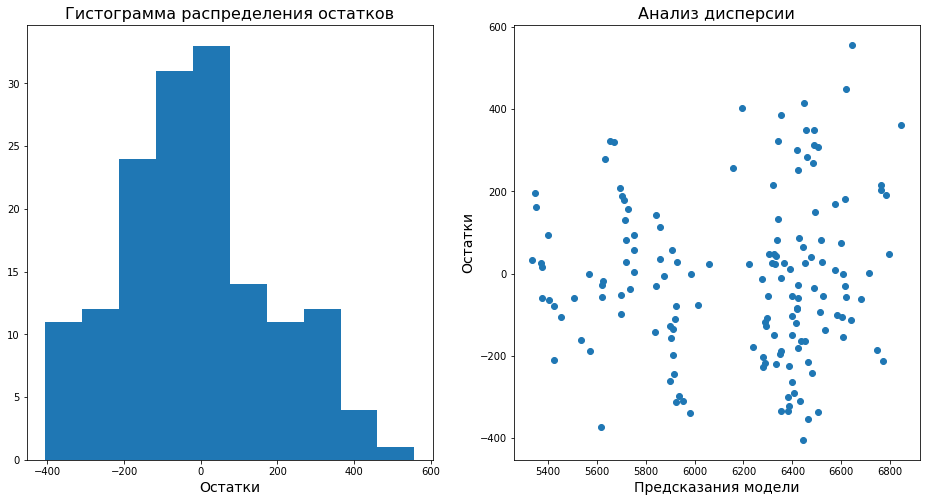

In [98]:
#Создаем модель №2:

#Задаем константу:
RANDOM_STATE = 42

#Отделяем целой признак и входные

#Входные признаки:
X = df_model_2.drop('milk_yield', axis=1)
#Целевой признак:
y = df_model_2['milk_yield']

X_train, X_test, y_train, y_test_m2 = train_test_split(X, y, random_state = RANDOM_STATE)


#Сохраняем функции в переменные для масштабирования и кодирования 
#encoder  = OneHotEncoder(drop='first', sparse=False)
#scaler = StandardScaler()

#Список всех категориальных переменных и список количественных:
cat_names = ['breed', 'type_pasture', 'dad_breed', 'age', 'spr']
num_names = ['efu', 'raw_protein', 'efu_squared']

#Обучим и трансформируем данные тренеровочной выборки:
X_train_scaled = scaler.fit_transform(X_train[num_names])

#Трансформируем тестовую выборку:
X_test_scaled = scaler.transform(X_test[num_names])                                     

#Обучим и трансформируем данные тренеровочной выборки:
X_train_ohe = encoder.fit_transform(X_train[cat_names])

#Трансформируем тестовую выборку:
X_test_ohe = encoder.transform(X_test[cat_names])

#Сохраним новые имена столбцов в переменной:
encoder_col_names = encoder.get_feature_names()

#Выборки категориальных переменных, после кодирования:
X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)
 
#Выборки количественных переменных, после масштабирования:                                      
X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_names)

#Итоговые преобразованные тренеровочная и тестовая выборки:                                      
X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

#Обучение модели линейной регрессии:

#Кладем модель в переменную:
#model_lr = LinearRegression()

#Находим коэффициенты:
model_lr.fit(X_train, y_train)

#Предсказываем результаты на тестовой выборке:
predictions_m2 = model_lr.predict(X_test)

# рассчитайте значение коэф.детерминации R2 для линейной регрессии:
r2 = r2_score(y_test_m2, predictions_m2)

print("R2 LinearRegression =", r2)


#АНАЛИЗ ОСТАТКОВ
#Рассчитаем остатки
residuals = y_test_m2 - predictions_m2

#Построим графики по количественным признакам — гистограмму частотности распределения и диаграмму рассеяния
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,8))
axes[0].hist(residuals, bins=10)
axes[0].set_title('Гистограмма распределения остатков', fontsize=16)
axes[0].set_xlabel('Остатки', fontsize=14)

axes[1].scatter(x=predictions_m2, y=residuals)
axes[1].set_xlabel('Предсказания модели', fontsize=14)
axes[1].set_ylabel('Остатки', fontsize=14)
axes[1].set_title('Анализ дисперсии', fontsize=16)
plt.show()

**Выводы к второй модели:**

> Коэффициент детерминации равен **0.8258** - это говорит о том, что модель стала предсказывать целевой признак **еще лучше/точней**, по срнавнению с первой моделью

> Гистограмма распределения остатков - **распределение равномерное**, всплеск - устранен, но теперь видно, что значений не хвататет (скорей всего отрезали лишнее)

> Из диаграммы рассеяния остатков: **дисперсия не смещена**, максимум значений по оси Y - свыше 400, минимум ниже -400.

> Из диаграммы рассеяния остатков: Имеется **чередование** значений дисперсии: 1.На интервале X: от начала до 5900 соответствуют диапозону значений Y: -300 ~ 300. 2.На интервале X: от 5900 до конца - соответствуют всему диапозону значений Y. Чередование значений дисперсии - **уменьшилось**, по сравнению с моделью №1, но все равно **присутствует**, **т.е. модель требуется доработать**

### Модель №3

Перед тем как создать третью модель, добавим изменения:
    
1. Добавим новый признак "Имя папы", посмотрим как модель себя поведет

2. Устраним нелинейности как и в случае со второй моделью

In [99]:
#Сохраним копию исходного датафрейма:
df_model_3 = df_main

In [100]:
#Перед соединением двух дф, сравним их размерности:
df_dad.shape

(629, 2)

In [101]:
#Размерность главного дф:
df_model_3.shape

(610, 12)

Исходя из размерностей - итоговый дф, должен содержать 604 строки:

In [102]:
#С помощью merge() соединим эти датафремы:
df_model_3 = df_model_3.merge(df_dad, on='id')

In [103]:
#Выведем первые 5-ть строк полученного дф:
df_model_3.head(5)

id  milk_yield   efu  raw_protein    spr    breed type_pasture dad_breed  \
0   1        5863  14.2         1743  0.890   айдиал    равнинное    айдиал   
1   2        5529  12.8         2138  0.890   айдиал    равнинное   соверин   
2   3        5810  14.0         1854  0.885  соверин    холмистое   соверин   
3   4        5895  12.4         2012  0.885  соверин    холмистое    айдиал   
4   5        5302  12.8         1675  0.885   айдиал    равнинное   соверин   

   fat_percent  protein_percent taste_milk          age  name_dad  
0         3.58            3.076     вкусно  более_2_лет    буйный  
1         3.54            3.079     вкусно  менее_2_лет  соловчик  
2         3.59            3.074  не вкусно  более_2_лет     барин  
3         3.40            3.075  не вкусно  более_2_лет    буйный  
4         3.73            3.073     вкусно  менее_2_лет     барин

In [104]:
#Посмотрим его размерность
df_model_3.shape

(610, 13)

Мы добавили столбец ***name_dad*** в датафрейм нашей модели по соответсвующим индексам, теперь выполним преобразования, которые делали ранее со второй моделью:

In [105]:
#Удалим из копии ненужные входные признаки:
df_model_3 = df_model_3.drop(['id', 'fat_percent', 'protein_percent', 'taste_milk'], axis=1)

#Добавляем новый входной признак ЭКЕ в квадрате:
df_model_3['efu_squared'] = df_model_3['efu'] ** 2

#С помощью лямбда-функции пробежимся по значениям столбца и изменим их в зависимотси от порога в 0.92:
df_model_3['spr'] = df_model_3['spr'].apply(lambda x: 0 if x <= 0.92 else 1)

#Теперь наш исходный дф для модели №3 принимает вид:
df_model_3.head(5)

milk_yield   efu  raw_protein  spr    breed type_pasture dad_breed  \
0        5863  14.2         1743    0   айдиал    равнинное    айдиал   
1        5529  12.8         2138    0   айдиал    равнинное   соверин   
2        5810  14.0         1854    0  соверин    холмистое   соверин   
3        5895  12.4         2012    0  соверин    холмистое    айдиал   
4        5302  12.8         1675    0   айдиал    равнинное   соверин   

           age  name_dad  efu_squared  
0  более_2_лет    буйный       201.64  
1  менее_2_лет  соловчик       163.84  
2  более_2_лет     барин       196.00  
3  более_2_лет    буйный       153.76  
4  менее_2_лет     барин       163.84

R2 LinearRegression = 0.8253448609887711


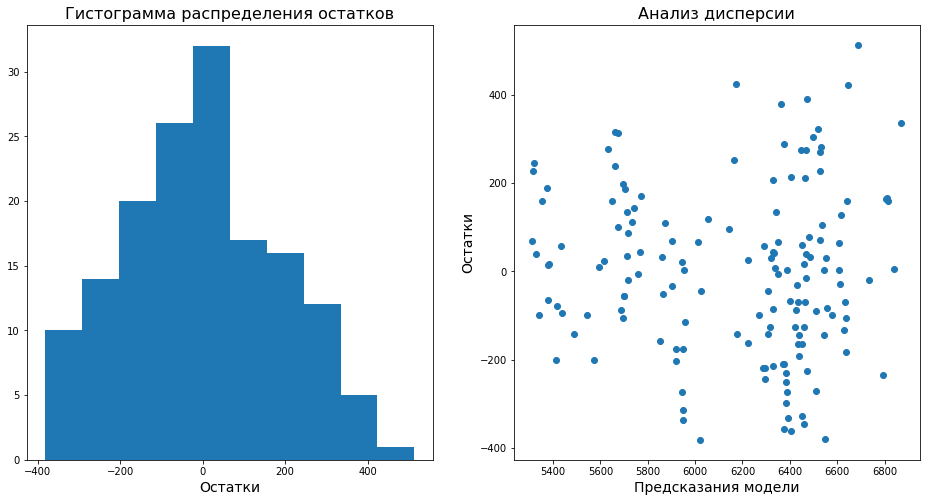

In [106]:
#Создаем модель №3:

#Задаем константу:
RANDOM_STATE = 42

#Отделяем целой признак и входные

#Входные признаки:
X = df_model_3.drop('milk_yield', axis=1)
#Целевой признак:
y = df_model_3['milk_yield']

X_train, X_test, y_train, y_test_m3 = train_test_split(X, y, random_state = RANDOM_STATE)


#Сохраняем функции в переменные для масштабирования и кодирования 
#encoder  = OneHotEncoder(drop='first', sparse=False)
#scaler = StandardScaler()

#Список всех категориальных переменных и список количественных:
cat_names = ['breed', 'type_pasture', 'dad_breed', 'age', 'spr', 'name_dad']
num_names = ['efu', 'raw_protein', 'efu_squared']

#Обучим и трансформируем данные тренеровочной выборки:
X_train_scaled = scaler.fit_transform(X_train[num_names])

#Трансформируем тестовую выборку:
X_test_scaled = scaler.transform(X_test[num_names])                                     

#Обучим и трансформируем данные тренеровочной выборки:
X_train_ohe = encoder.fit_transform(X_train[cat_names])

#Трансформируем тестовую выборку:
X_test_ohe = encoder.transform(X_test[cat_names])

#Сохраним новые имена столбцов в переменной:
encoder_col_names = encoder.get_feature_names()

#Выборки категориальных переменных, после кодирования:
X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)
 
#Выборки количественных переменных, после масштабирования:                                      
X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_names)

#Итоговые преобразованные тренеровочная и тестовая выборки:                                      
X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

#Обучение модели линейной регрессии:

#Кладем модель в переменную:
#model_lr = LinearRegression()

#Находим коэффициенты:
model_lr.fit(X_train, y_train)

#Предсказываем результаты на тестовой выборке:
predictions_m3 = model_lr.predict(X_test)

# рассчитайте значение коэф.детерминации R2 для линейной регрессии:
r2 = r2_score(y_test_m3, predictions_m3)

print("R2 LinearRegression =", r2)


#АНАЛИЗ ОСТАТКОВ
#Рассчитаем остатки
residuals = y_test_m3 - predictions_m3

#Построим графики по количественным признакам — гистограмму частотности распределения и диаграмму рассеяния
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,8))
axes[0].hist(residuals, bins=10)
axes[0].set_title('Гистограмма распределения остатков', fontsize=16)
axes[0].set_xlabel('Остатки', fontsize=14)

axes[1].scatter(x=predictions_m3, y=residuals)
axes[1].set_xlabel('Предсказания модели', fontsize=14)
axes[1].set_ylabel('Остатки', fontsize=14)
axes[1].set_title('Анализ дисперсии', fontsize=16)
plt.show()

**Выводы к третьей модели:**

> Коэффициент детерминации равен **0.8452** - модель стала еще **более точной**

> Гистограмма распределения остатков - **распределение равномерное**, относительно нуля стало **более симметричным**, по сравнению с предыдущими моделям

> Из диаграммы рассеяния остатков: **дисперсия не смещена**, максимум значений по оси Y - свыше 400, минимум ниже -400.

> Из диаграммы рассеяния остатков: **Чередование** значений дисперсии все также присутствует, разброс меньше для диапозона по Х: от начала до 6000, свыше 6000 разброс увеличивается

### Сравнение моделей

Посмотрим на различные метрики оценки моделей, чтобы определиться с выбором модели, которую будем использовать для предсказания целевой переменной:

In [107]:
#Сохраним итоговые параметры трёх моделей в отдельный список:
params = [[y_test_m1, predictions_m1], [y_test_m2, predictions_m2], [y_test_m3, predictions_m3]]

for i in range(3):
    print(f'Метрики модели №{i+1}')
    print(f'MSE: {mean_squared_error(params[i][0], params[i][1]):.4f}')
    print(f'RMSE: {mean_squared_error(params[i][0], params[i][1], squared=False):.4f}')
    print(f'MAE: {mean_absolute_error(params[i][0], params[i][1]):.4f}')
    print(f'R2: {r2_score(params[i][0], params[i][1]):.4f}')
    print()

Метрики модели №1
MSE: 43515.6281
RMSE: 208.6040
MAE: 167.5013
R2: 0.7855

Метрики модели №2
MSE: 37983.9989
RMSE: 194.8948
MAE: 154.9575
R2: 0.8127

Метрики модели №3
MSE: 35427.8886
RMSE: 188.2230
MAE: 151.3219
R2: 0.8253



Как видно, из полученных значений метрик, **Модель №3** имеет наилучшие показатели по всем метрикам:

> Наименьшая средняя квардратическая ошибка (MSE) 

> Наименьший корень средней квардратической ошибки (RMSE) 

> Наименьшая средняя абсолютная ошибка (MAE)

> Наибольший показатель детерминации (R2) - чем больше, тем точнее предсказание, относительно среднего

Определим доверительный интервал прогноза для выбранной модели

In [108]:
#Расчитаем интервал, в который попадет 95% значений прогноза:
dov_l_3 = st.norm.interval(0.95, loc=np.mean(predictions_m3), scale=st.sem(predictions_m3))
print(dov_l_3)

(6096.559068903111, 6229.233729261668)


### Применение полученной модели

Добавим в датафрейм недостоющие признаки (ЭКЕ, СПО, Сырой протеин), возьмем средние значения и увеличим их на 5%

In [109]:
#Выведем исходный дф:
df_cow.head(5)

breed type_pasture dad_breed  name_dad  current_fat_percent  \
0   айдиал    холмистое    айдиал  геркулес                 3.58   
1   айдиал    равнинное   соверин    буйный                 3.54   
2  соверин    равнинное   соверин     барин                 3.59   
3  соверин    холмистое    айдиал    буйный                 3.40   
4  соверин    равнинное    айдиал    буйный                 3.64   

   current_protein_percent          age  
0                    3.076  более_2_лет  
1                    3.081  менее_2_лет  
2                    3.074  более_2_лет  
3                    3.061  более_2_лет  
4                    3.074  более_2_лет

In [110]:
#Создадим новую переменную в которую сохзраним копию cow_buy:
df_cow_test_x = df_cow.copy()

#Добавляем новые признаки:
#ЭКЕ
df_cow_test_x['efu'] = df_main['efu'].mean() * 1.05
#СПО
df_cow_test_x['spr'] = df_main['spr'].mean() * 1.05
#Сырой протеин
df_cow_test_x['raw_protein'] = df_main['raw_protein'].mean() * 1.05

#Добавим столбец efu_squared:
df_cow_test_x['efu_squared'] = df_cow_test_x['efu'] ** 2

#Приведем переменную к категориальному виду с помощью бинарной классификации:
df_cow_test_x['spr'] = df_cow_test_x['spr'].apply(lambda x: 0 if x <= 0.92 else 1)

#Удалим ненужные параметры:
df_cow_test_x = df_cow_test_x.drop(['current_fat_percent', 'current_protein_percent'], axis=1)


df_cow_test_x.head()

breed type_pasture dad_breed  name_dad          age        efu  spr  \
0   айдиал    холмистое    айдиал  геркулес  более_2_лет  15.284385    1   
1   айдиал    равнинное   соверин    буйный  менее_2_лет  15.284385    1   
2  соверин    равнинное   соверин     барин  более_2_лет  15.284385    1   
3  соверин    холмистое    айдиал    буйный  более_2_лет  15.284385    1   
4  соверин    равнинное    айдиал    буйный  более_2_лет  15.284385    1   

   raw_protein  efu_squared  
0  2020.857541   233.612432  
1  2020.857541   233.612432  
2  2020.857541   233.612432  
3  2020.857541   233.612432  
4  2020.857541   233.612432

Теперь необходимо отмасштабировать и закодировать значения, чтобы мы могли использовать данную таблицу в качестве тестовой выборки модели №3:

In [111]:
#Список всех категориальных переменных и список количественных:
cat_names = ['breed', 'type_pasture', 'dad_breed', 'age', 'spr', 'name_dad']
num_names = ['efu', 'raw_protein', 'efu_squared']


#Трансформируем тестовую выборку:
X_test_scaled = scaler.transform(df_cow_test_x[num_names])                                     


#Трансформируем тестовую выборку:
X_test_ohe = encoder.transform(df_cow_test_x[cat_names])

#Сохраним новые имена столбцов в переменной:
encoder_col_names = encoder.get_feature_names()

#Выборки категориальных переменных, после кодирования:

X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)
 
#Выборки количественных переменных, после масштабирования:                                      

X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_names)

#Итоговые преобразованные тренеровочная и тестовая выборки:                                      

X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

#Сохраним новые имена столбцов в переменной:
encoder_col_names = encoder.get_feature_names()

X_test.head(5)

x0_соверин  x1_холмистое  x2_соверин  x3_менее_2_лет  x4_1  x5_буйный  \
0         0.0           1.0         0.0             0.0   1.0        0.0   
1         0.0           0.0         1.0             1.0   1.0        1.0   
2         1.0           0.0         1.0             0.0   1.0        0.0   
3         1.0           1.0         0.0             0.0   1.0        1.0   
4         1.0           0.0         0.0             0.0   1.0        1.0   

   x5_геркулес  x5_соловчик       efu  raw_protein  efu_squared  
0          1.0          0.0  0.578639     0.541735      0.55371  
1          0.0          0.0  0.578639     0.541735      0.55371  
2          0.0          0.0  0.578639     0.541735      0.55371  
3          0.0          0.0  0.578639     0.541735      0.55371  
4          0.0          0.0  0.578639     0.541735      0.55371

Теперь можно предсказывать результаты целевой переменной:

In [112]:
#Предсказываем результаты на тестовой выборке:
predictions_last = model_lr.predict(X_test)
 
predictions_last

array([6563.50793219, 6290.35893696, 6278.6381687 , 6586.84903615,
       6522.44247661, 6341.65077868, 6563.50793219, 6546.41598988,
       6278.6381687 , 6330.79198323, 6337.37169906, 6597.7078316 ,
       6563.50793219, 6049.67120248, 6278.6381687 , 6586.84903615,
       6337.37169906, 6341.65077868, 6546.41598988, 6522.44247661])

Выполним проверку размерности и количества предсказанных переменных:

In [113]:
#Проверим размер полученной тестовой выборки:
X_test.shape

(20, 11)

In [114]:
#Количество коэффициентов совпадает с количеством столбцов:
len(model_lr.coef_)

11

In [115]:
len(predictions_last)

20

Итак, количество коэффициентов и столбцов - совпадает, как и количество искомых целевых переменных:

In [116]:
#Получаем итоговые предсказания ввиде столбца с целевыми перемеными:
pd.Series(predictions_last)

0     6563.507932
1     6290.358937
2     6278.638169
3     6586.849036
4     6522.442477
5     6341.650779
6     6563.507932
7     6546.415990
8     6278.638169
9     6330.791983
10    6337.371699
11    6597.707832
12    6563.507932
13    6049.671202
14    6278.638169
15    6586.849036
16    6337.371699
17    6341.650779
18    6546.415990
19    6522.442477
dtype: float64

<a id='section_6'></a>

## Обучение модели логистической регрессии

### Модель логистической регрессии

1. В качестве целового приизнака будем использовать **Вкус молока** (*taste_milk*)

2. Количество произведенного молока за год - не влияет на его вкус, из логических соображений, поэтому избавимся от параметра **Удой**

3. Также следует удалить столбец **id**, который не влияет на вкус молока

In [117]:
#Создаем копию исходного датафрейма:
df_log = df_main

In [118]:
#Удалим из копии ненужные входные признаки:
df_log = df_log.drop(['id', 'milk_yield'], axis=1)

In [119]:
#Заменяем значения в taste_milk на 0 и 1:
df_log['taste_milk'] = df_log['taste_milk'].replace('не вкусно', 0)
df_log['taste_milk'] = df_log['taste_milk'].replace('вкусно', 1)

In [120]:
#Приведем СПО к категориальному виду:
df_log['spr'] = df_log['spr'].apply(lambda x: 0 if x <= 0.92 else 1)

In [121]:
#Изначальный вид нашего дф для задачи логистической регрессии:
df_log.head(5)

efu  raw_protein  spr    breed type_pasture dad_breed  fat_percent  \
0  14.2         1743    0   айдиал    равнинное    айдиал         3.58   
1  12.8         2138    0   айдиал    равнинное   соверин         3.54   
2  14.0         1854    0  соверин    холмистое   соверин         3.59   
3  12.4         2012    0  соверин    холмистое    айдиал         3.40   
4  12.8         1675    0   айдиал    равнинное   соверин         3.73   

   protein_percent  taste_milk          age  
0            3.076           1  более_2_лет  
1            3.079           1  менее_2_лет  
2            3.074           0  более_2_лет  
3            3.075           0  более_2_лет  
4            3.073           1  менее_2_лет

In [122]:
#Разобьем датафрейм на обучающую и тестовую выборки, выделим целевой признак:

#Входные признаки:
X = df_log.drop('taste_milk', axis=1)
#Целевой признак:
y = df_log['taste_milk']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = RANDOM_STATE)

#создадим списки количественных и категориальных: 
cat_names = ['spr', 'breed', 'type_pasture', 'dad_breed', 'age']
num_names = ['efu', 'raw_protein', 'fat_percent', 'protein_percent']

#Масштабируем:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_names])
X_test_scaled = scaler.transform(X_test[num_names])

#Кодируем:
encoder = OneHotEncoder(drop='first', sparse=False)
X_train_ohe = encoder.fit_transform(X_train[cat_names])
X_test_ohe = encoder.transform(X_test[cat_names])

#Сохраним новые имена столбцов в переменной:
encoder_col_names = encoder.get_feature_names()

#Выборки категориальных переменных, после кодирования:
X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)
 
#Выборки количественных переменных, после масштабирования:                                      
X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_names)

#Итоговые преобразованные тренеровочная и тестовая выборки:                                      
X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

#Вид тренеровочной выборки после кодирования и масштабирования:
X_train.head(5)

x0_1  x1_соверин  x2_холмистое  x3_соверин  x4_менее_2_лет       efu  \
0   1.0         0.0           1.0         0.0             0.0  1.277480   
1   1.0         1.0           1.0         0.0             0.0  1.048506   
2   0.0         0.0           0.0         1.0             0.0 -2.080812   
3   1.0         1.0           1.0         1.0             0.0  0.972181   
4   0.0         1.0           0.0         1.0             0.0 -0.783290   

   raw_protein  fat_percent  protein_percent  
0     1.395124     0.634852        -1.114356  
1     1.319095     0.693099        -1.536278  
2    -1.396241    -0.937812        -1.114356  
3     2.242309     0.693099         0.995257  
4    -1.086693     0.052384         0.151412

In [123]:
#Сохраним в переменную модель мультиклассовой логистической регрессии:
clf = OneVsRestClassifier(LogisticRegression())

#Обучим модель:
clf = clf.fit(X_train, y_train)

#Получим прогноз класса:
y_pred = clf.predict(X_test)

#Получим прогноз вероятности для класса:
y_proba = clf.predict_proba(X_test)

### Матрица ошибок

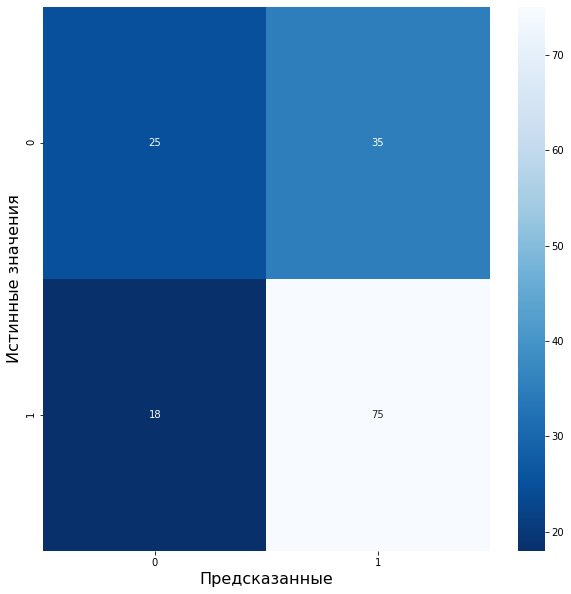

In [124]:
#Построим матрицу ошибок:
plt.figure(figsize=(10,10))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
plt.ylabel('Истинные значения', fontsize=16)
plt.xlabel('Предсказанные', fontsize=16)
plt.show()

### Расчет accuracy, precision, recall

In [125]:
acc = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

print('acc:', acc)
print('recall:', recall)
print('precision:', precision)

acc: 0.6535947712418301
recall: 0.8064516129032258
precision: 0.6818181818181818


***Precision*** (Точность) - минимизирует ошибку первого рода, не учитывая остальные параметры. Данный параметр характеризует, насколько точно модель дает предсказания: чем она ближе к 1, тем сильней FP - стремится к нулю. Иными словами, precision определяет, не слишком ли часто модель выставляет класс 1 объектам класса 0

$$Precision = \frac{TP}{TP + FP}$$

***FP*** - алгоритм предсказал 1, реальность 0. (предсказалия, что молоко вкусное - оказалось наоборот)

***recall*** (Полнота) - минимизирует ошибку второго рода. Обратна по оношению к *precision*. Она измеряет, смогла ли модель классификации присвоить класс 1 всем объектам этого класса. Чем выше recall - тем больше прогнозов модель смогла дать верно.

$$Recall = \frac{TP}{TP + FN}$$

***FN*** - алгоритм предсказал 0, реальность 1. (предсказалия, что молоко не вкусное - оказалось наоборот)

> На данном этапе precision, как видно из матрицы ошибок, выдает большое количество ошибок 1-го рода. Это говорит о том, что модель ошибается с выставлением классов достаточно часто. Ставит класс 1 объектам класса 0 (**36 случаев**)

> В противовес precision выступает recall, который говорит, что большенству объектов класса 1 выставлен 1 класс. Из всех случаев только (**17 раз**) объектку класса 0 был присвоен класс 1.

В рамках нашей задачи главное чтобы итоговый продукт был **вкусным**. Но лучше ошибится и **не поставить правильный вкус**, в случае работы алгоритма, нежели задать объекту класс "вкусный", когда он таким не является. Из этого следует, что нужно **минимизировать FP** - следовательно, **precision - должен расти**, а recall - падать. Другими словами, ошибка 1 рода в данной задаче является более **актуальной**, нежели ошибка второго рода

### Подбор порога

In [126]:
y_proba = clf.predict_proba(X_test)[:,1]

data = pd.DataFrame(zip(y_test, y_proba),
             columns = ['y_valid', 'y_proba']).sort_values(by='y_proba',ascending=False)

print(data.head()) 

     y_valid   y_proba
126        1  0.880543
100        1  0.864696
147        1  0.861383
112        1  0.847891
111        1  0.837440


In [127]:
#Создадим список граничных значений:
thresholds = [round(i,2) for i in np.linspace(0.5,0.9,num = 10,endpoint=False)]
print(thresholds) 

[0.5, 0.54, 0.58, 0.62, 0.66, 0.7, 0.74, 0.78, 0.82, 0.86]


In [128]:
columns=[]

#Переберем пороги и добавим их в виде столбцов в дф:
for i in thresholds:
    columns.append('y_pred_'+ str(i))
    data['y_pred_' + str(i)] = data['y_proba'].apply(lambda x: 1 if x>= i else 0)

In [129]:
#Пример таблицы пороговых знаечний:
data

y_valid   y_proba  y_pred_0.5  y_pred_0.54  y_pred_0.58  y_pred_0.62  \
126        1  0.880543           1            1            1            1   
100        1  0.864696           1            1            1            1   
147        1  0.861383           1            1            1            1   
112        1  0.847891           1            1            1            1   
111        1  0.837440           1            1            1            1   
..       ...       ...         ...          ...          ...          ...   
151        1  0.292919           0            0            0            0   
31         0  0.260209           0            0            0            0   
45         1  0.246913           0            0            0            0   
16         0  0.240989           0            0            0            0   
132        1  0.233277           0            0            0            0   

     y_pred_0.66  y_pred_0.7  y_pred_0.74  y_pred_0.78  y_pred_0.82  \
126            1           1            1            1            1   
100            1           1            1            1            1   
147            1           1            1            1            1   
112            1           1            1            1            1   
111            1           1            1            1            1   
..           ...         ...          ...          ...          ...   
151            0           0            0            0            0   
31             0           0            0            0            0   
45             0           0            0            0            0   
16             0           0            0            0            0   
132            0           0            0            0            0   

     y_pred_0.86  
126            1  
100            1  
147            1  
112            0  
111            0  
..           ...  
151            0  
31             0  
45             0  
16             0  
132            0  

[153 rows x 12 columns]

In [130]:
#Посмотрим, как будет меняться precision с увеличением порога:
probabilities_one_valid = clf.predict_proba(X_test)[:,1]

for i in np.arange(0.5, 0.9, 0.02).round(2):
    y_pred = probabilities_one_valid > i
    print('порог: ', i, 'precision: ', precision_score(y_test, y_pred))

порог:  0.5 precision:  0.6818181818181818
порог:  0.52 precision:  0.6792452830188679
порог:  0.54 precision:  0.6831683168316832
порог:  0.56 precision:  0.7040816326530612
порог:  0.58 precision:  0.7065217391304348
порог:  0.6 precision:  0.7325581395348837
порог:  0.62 precision:  0.7468354430379747
порог:  0.64 precision:  0.7647058823529411
порог:  0.66 precision:  0.8
порог:  0.68 precision:  0.7755102040816326
порог:  0.7 precision:  0.7777777777777778
порог:  0.72 precision:  0.8
порог:  0.74 precision:  0.7878787878787878
порог:  0.76 precision:  0.9285714285714286
порог:  0.78 precision:  0.9166666666666666
порог:  0.8 precision:  0.9285714285714286
порог:  0.82 precision:  1.0
порог:  0.84 precision:  1.0
порог:  0.86 precision:  1.0
порог:  0.88 precision:  1.0


Как видно модель, перестает ошибаться при **порое 0.82**, **precision** становится максимальным

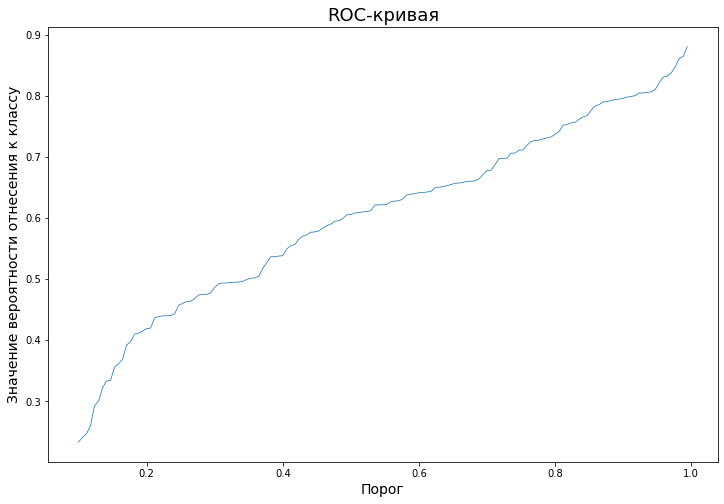

In [131]:
thresholds = [round(i,5) for i in np.linspace(0.1,1,num = 153,endpoint=False)]

plt.figure(figsize=(12,8))
heatmap = sns.lineplot(x=thresholds, y=data['y_proba'].sort_values(), size = 50, 
                    legend=False)
plt.xlabel('Порог', fontsize=14)
plt.ylabel('Значение вероятности отнесения к классу', fontsize=14)
plt.title('ROC-кривая', fontsize=18)
plt.show()

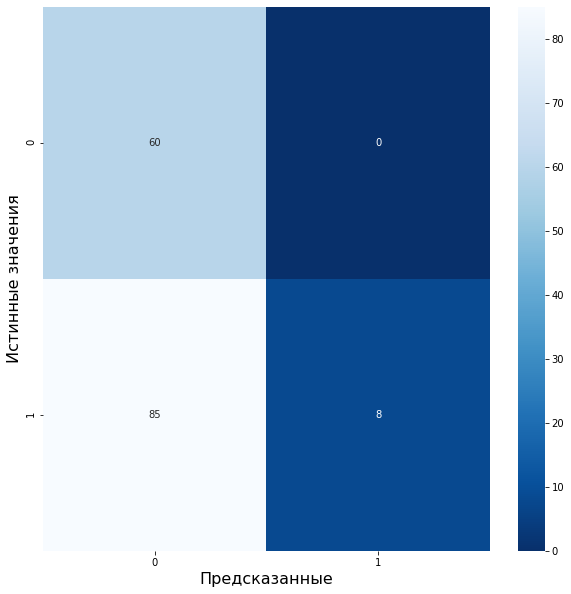

In [132]:
#Построим матрицу ошибок:
plt.figure(figsize=(10,10))
cm = confusion_matrix(data['y_valid'], data['y_pred_0.82'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
plt.ylabel('Истинные значения', fontsize=16)
plt.xlabel('Предсказанные', fontsize=16)
plt.show()

In [133]:
acc = accuracy_score(data['y_valid'], data['y_pred_0.82'])
recall = recall_score(data['y_valid'], data['y_pred_0.82'])
precision = precision_score(data['y_valid'], data['y_pred_0.82'])

print('acc:', acc)
print('recall:', recall)
print('precision:', precision)

acc: 0.4444444444444444
recall: 0.08602150537634409
precision: 1.0


> Выявили необходимое пороговое значение, равное **0.82**, при нем ***precision*** равен единице

> Свели ошибку первого рода к нулю

> Улучшили модель

> Также можно заметить, что **TN** - тоже увеличился, т.е. количество верных предсказаний (предсказание "не вкусное" / реальность "не вкусное") повысилось.

### Прогноз вкуса

Мы сделали модель, определили пороги, чтобы предсказывать необходимые нам результаты, осталось только применить её к нашим данным. Но в начале данные надо привести к должному виду:

In [134]:
#Создадим новую переменную в которую сохзраним копию cow_buy:
df_log_last = df_cow.copy()

#Добавляем новые признаки:
#ЭКЕ
df_log_last ['efu'] = df_main['efu'].mean() * 1.05
#СПО
df_log_last['spr'] = df_main['spr'].mean() * 1.05
#Сырой протеин
df_log_last['raw_protein'] = df_main['raw_protein'].mean() * 1.05

#Приведем переменную к категориальному виду с помощью бинарной классификации:
df_log_last['spr'] = df_log_last['spr'].apply(lambda x: 0 if x <= 0.92 else 1)

#Удалим столбец:
df_log_last = df_log_last.drop(['name_dad'], axis=1)

df_log_last.head()

breed type_pasture dad_breed  current_fat_percent  \
0   айдиал    холмистое    айдиал                 3.58   
1   айдиал    равнинное   соверин                 3.54   
2  соверин    равнинное   соверин                 3.59   
3  соверин    холмистое    айдиал                 3.40   
4  соверин    равнинное    айдиал                 3.64   

   current_protein_percent          age        efu  spr  raw_protein  
0                    3.076  более_2_лет  15.284385    1  2020.857541  
1                    3.081  менее_2_лет  15.284385    1  2020.857541  
2                    3.074  более_2_лет  15.284385    1  2020.857541  
3                    3.061  более_2_лет  15.284385    1  2020.857541  
4                    3.074  более_2_лет  15.284385    1  2020.857541

In [135]:
#Список всех категориальных переменных и список количественных:
cat_names = ['spr', 'breed', 'type_pasture', 'dad_breed', 'age']
num_names = ['efu', 'raw_protein', 'current_fat_percent', 'current_protein_percent']


#Трансформируем тестовую выборку:
X_test_scaled = scaler.transform(df_log_last[num_names])                                     


#Трансформируем тестовую выборку:
X_test_ohe = encoder.transform(df_log_last[cat_names])

#Сохраним новые имена столбцов в переменной:
encoder_col_names = encoder.get_feature_names()

#Выборки категориальных переменных, после кодирования:

X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)
 
#Выборки количественных переменных, после масштабирования:                                      

X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_names)

#Итоговые преобразованные тренеровочная и тестовая выборки:                                      

X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

#Сохраним новые имена столбцов в переменной:
encoder_col_names = encoder.get_feature_names()

X_test.head(5)

x0_1  x1_соверин  x2_холмистое  x3_соверин  x4_менее_2_лет       efu  \
0   1.0         0.0           1.0         0.0             0.0  0.578639   
1   1.0         0.0           0.0         1.0             1.0  0.578639   
2   1.0         1.0           0.0         1.0             0.0  0.578639   
3   1.0         1.0           1.0         0.0             0.0  0.578639   
4   1.0         1.0           0.0         0.0             0.0  0.578639   

   raw_protein  current_fat_percent  current_protein_percent  
0     0.541735            -0.122357                 0.151412  
1     0.541735            -0.355344                 2.261025  
2     0.541735            -0.064110                -0.692433  
3     0.541735            -1.170799                -6.177427  
4     0.541735             0.227124                -0.692433

In [136]:
X_test.shape

(20, 9)

In [137]:
#Получаем оценки вероятностей отнесения к классу:
y_proba = clf.predict_proba(X_test)[:,1]

#Метки классов:
y_proba

array([0.74349369, 0.59648402, 0.53502839, 0.63443288, 0.54325129,
       0.26719126, 0.74349369, 0.61216074, 0.53502839, 0.75876324,
       0.46994972, 0.48255573, 0.41104173, 0.71713464, 0.53502839,
       0.67376398, 0.71575813, 0.23584883, 0.5732811 , 0.54325129])

In [138]:
y_pred = pd.Series(y_proba).apply(lambda x: 1 if x>0.82 else 0)

#Получившиеся знаечния:
y_pred

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
dtype: int64

In [139]:
#Проверка размерности
y_pred.shape

(20,)

In [140]:
#Добавим в таблицу вектор столбец с предсказаниями вкуса:
df_cow['taste_milk_predict'] = y_pred

#приведем к изначальным значениям:
df_cow['taste_milk_predict'] = df_cow['taste_milk_predict'].replace(0, 'не вкусно')
df_cow['taste_milk_predict'] = df_cow['taste_milk_predict'].replace(0, 'вкусно')

#Добавим в таблицу вектор столбец с предсказаниями удоя:
df_cow['milk_yield_predict'] = predictions_last

In [141]:
df_cow.reset_index(drop=True)

breed type_pasture dad_breed  name_dad  current_fat_percent  \
0    айдиал    холмистое    айдиал  геркулес                 3.58   
1    айдиал    равнинное   соверин    буйный                 3.54   
2   соверин    равнинное   соверин     барин                 3.59   
3   соверин    холмистое    айдиал    буйный                 3.40   
4   соверин    равнинное    айдиал    буйный                 3.64   
5   соверин    равнинное   соверин  геркулес                 3.63   
6    айдиал    холмистое    айдиал  геркулес                 3.58   
7    айдиал    равнинное   соверин    буйный                 3.57   
8   соверин    равнинное   соверин     барин                 3.59   
9   соверин    холмистое    айдиал    буйный                 3.40   
10   айдиал    холмистое   соверин  соловчик                 3.73   
11  соверин    равнинное   соверин  геркулес                 3.73   
12   айдиал    холмистое    айдиал  геркулес                 3.68   
13   айдиал    холмистое   соверин     барин                 3.42   
14  соверин    равнинное   соверин     барин                 3.59   
15  соверин    холмистое    айдиал    буйный                 3.40   
16   айдиал    холмистое   соверин  соловчик                 3.73   
17  соверин    равнинное   соверин  геркулес                 3.77   
18   айдиал    равнинное   соверин    буйный                 3.34   
19  соверин    равнинное    айдиал    буйный                 3.64   

    current_protein_percent          age taste_milk_predict  \
0                     3.076  более_2_лет          не вкусно   
1                     3.081  менее_2_лет          не вкусно   
2                     3.074  более_2_лет          не вкусно   
3                     3.061  более_2_лет          не вкусно   
4                     3.074  более_2_лет          не вкусно   
5                     3.053  менее_2_лет          не вкусно   
6                     3.076  более_2_лет          не вкусно   
7                     3.079  более_2_лет          не вкусно   
8                     3.074  более_2_лет          не вкусно   
9                     3.079  менее_2_лет          не вкусно   
10                    3.055  более_2_лет          не вкусно   
11                    3.073  более_2_лет          не вкусно   
12                    3.046  более_2_лет          не вкусно   
13                    3.075  менее_2_лет          не вкусно   
14                    3.074  более_2_лет          не вкусно   
15                    3.065  более_2_лет          не вкусно   
16                    3.079  более_2_лет          не вкусно   
17                    3.053  менее_2_лет          не вкусно   
18                    3.069  более_2_лет          не вкусно   
19                    3.074  более_2_лет          не вкусно   

    milk_yield_predict  
0          6563.507932  
1          6290.358937  
2          6278.638169  
3          6586.849036  
4          6522.442477  
5          6341.650779  
6          6563.507932  
7          6546.415990  
8          6278.638169  
9          6330.791983  
10         6337.371699  
11         6597.707832  
12         6563.507932  
13         6049.671202  
14         6278.638169  
15         6586.849036  
16         6337.371699  
17         6341.650779  
18         6546.415990  
19         6522.442477

> С помощью модели логистической регрессии спрогнозировали значение вкуса молока по описательным признакам

> В результате получен вектор-столбец целевой переменной все значения которого равны 0, это говорит о том, что по результатам работы модели, молоко во всех случаях окажется не вкусным при пороге 0.82

<a id='section_7'></a>

## Итоговый выводы

**1. На первом шаге была выгружена и изучена общая информация**

- Имеется три датафрейма, содержащие описательные признаки корма и коров

- ***df_main*** - содержит данные о стаде фермера на текущий момент. Объем дф:

> 634 строки, 12 столбцов

- ***df_dad*** - хранит имя папы каждой коровы в стаде фермера. Объем дф:

> 629 строк, 2 столбца

- ***df_cow***  - это данные о коровах «ЭкоФермы», которых фермер хочет изучить перед покупкой. Объем дф:

> 20 строк, 7 столбцов

Сделали первичный осмотр данных, которые задали вектор направления нашего анализа.

---

**2. На втором шаге была выполнена предобработка данных**

- Изменили названия столбцов (привели к нижнему регистру и перевели на латиницу)

- В таблице **не было выявлено пропусков** по результатам предобработки

- В данных были обнаружены **явные дубликаты** в сумме на три таблице их количество оказалось равно **9**

- На этапе предобработки мы потеряли **0.39%** от исходного объема данных, что допустимо. (Оптимально 5-10%)

---

**3. Провели исследовательский анализ данных**

- Для всех количественных переменных были построены гистограммы частотности

- Большенство распределений по гистограммам схоже с **нормальным**. Также большая часть переменных была распределена дискретно, это связано с тем, что значения для определенных интервалов повторялись

- Выполнены проверки на наличие аномальных значений по средствам **boxplot'ов**. Все возможные аномалии были удалены

---

**4. Корреляционный анализ**

Изначально задались условием, что в качестве целевого признака будет выступать **Удой** (количество литров молока, которая корова приносит за год)

- Построили матрицу корреляции по всем количественным переменным датафрейма *df_main*, визуализировали её с помощью тепловой карты. По полученной матрице были сделаны определенные выводы:

> Самые сильно коррелирующие признаки с **целевой переменной** это: ЭКЕ, СПО и Жирность

> Также было выявлено, что данные признаки коррелируют между собой, но **мультиколлинеарность** не наблюдается 

После просмотра всех взаимосвязей по всех категориальным признакам были сделаны определенные умозаключения по типу линейности и взаимосвязи переменных.

---

**5. Обучение модели линейной регрессии**

**5.1 Создание модели №1.**

По итогам анализа корреляции было принято решение о том, какие признаки использовать для обучения модели линейной регрессии. Исходя из аналитических соображений было принято исключить следующие признаки:

- Характеристики молока не влияют на удой, в отличие от параметров корма. Поэтому исключаем из модели такие признаки как: fat_percent, protein_percent и taste_milk - числовые и описательные характеристики молока

- Также было принято решение не учитывать параметр **Жирность**, посколько на этапе исследовательского анализа в нем было выявлено большое количество выбросов, которые негативно могли повлиять на результат предсказания модели

Данные признаки не несут сильного влияния на целевую переменную **Удой**

**Выводы к первой модели:**

> Коэффициент детерминации равен **0.7854** - это говорит о том, что модель **хорошо** предсказывает целевой признак

> Гистограмма распределения остатков - **распределение равномерное**, есть небольшой всплеск, возможно из-за неудаленных аномалий

> Из диаграммы рассеяния остатков: **дисперсия смещена** вниз, максимум значений по оси Y - свыше 400, минимум  -600. Не сильное, но смещение - имеется.

> Из диаграммы рассеяния остатков: Имеется **чередование** значений дисперсии: 1.На интервале X: 5000-6000 соответствуют диапозону значений Y: -400 ~ 200 (400) - два значения доходят до 400 и выше - **таких мало**. 2.На интервале X: от 6000 до конца - соответствуют всему диапозону значений Y. Может не сильно явное, но **чередование значений дисперсии - есть**. Это говорит о том, что **модель требует доработки**

**5.2 Создание модели №2.**

При создании второй модели мы учли следующие факторы:

- Графики диаграммы рассеяния показывают, что СПО и Удой связаны нелинейно. Попробуем устранить эту нелинейность, выберем границу, равную **0.92** (По знаечнию СПО) и по ней будем классифицировать признаки **бинарно**, все что будет больше порогового значения будет **1**, остальные **0**. (Поменяем количественный признак на категориальный)

- Если посомтреть на диаграмму рассеяния для Удоя и ЭКЕ, также можно заметить - **нелинейность**. Эту нелинейность попробуем исключить **добавив новый признак** - ЭКЕ возведенное в квадрат

**Выводы к второй модели:**

> Коэффициент детерминации равен **0.8127** - это говорит о том, что модель стала предсказывать целевой признак **еще лучше/точней**, по срнавнению с первой моделью

> Гистограмма распределения остатков - **распределение равномерное**, всплеск - устранен, но теперь видно, что значений не хвататет (скорей всего отрезали лишнее)

> Из диаграммы рассеяния остатков: **дисперсия не смещена**, максимум значений по оси Y - свыше 400, минимум ниже -400.

> Из диаграммы рассеяния остатков: Имеется **чередование** значений дисперсии: 1.На интервале X: от начала до 5900 соответствуют диапозону значений Y: -300 ~ 300. 2.На интервале X: от 5900 до конца - соответствуют всему диапозону значений Y. Чередование значений дисперсии - **уменьшилось**, по сравнению с моделью №1, но все равно **присутствует**, **т.е. модель требуется доработать**

**5.3 Создание модели №3.**

При создании третьей модели добавили изменения:
    
- Добавим новый признак "Имя папы", посмотрим как модель себя поведет

- Устраним нелинейности как и в случае со второй моделью

**Выводы к третьей модели:**

> Коэффициент детерминации равен **0.8253** - модель стала еще **более точной**

> Гистограмма распределения остатков - **распределение равномерное**, относительно нуля стало **более симметричным**, по сравнению с предыдущими моделям

> Из диаграммы рассеяния остатков: **дисперсия не смещена**, максимум значений по оси Y - свыше 400, минимум ниже -400.

> Из диаграммы рассеяния остатков: **Чередование** значений дисперсии все также присутствует, разброс меньше для диапозона по Х: от начала до 6000, свыше 6000 разброс увеличивается

**5.4 Результат сравнения**

Сравнение моделей проводилось по средсвам метрик (**MSE, RMSE, MAE, R2**) и остатков, было выявлено, что третья модель лучше всего подходит для использования предсказаний значений **Удоя**

- Применили полученную модель к датафрейму df_cow

- По результатам моделирования получили вектор-столбец предсказанных переменных целевого признака **удоя**

**6. Обучение модели логистической регрессии**

При создании модели учли следующие факторы:

- В качестве целового приизнака использовали **Вкус молока** (*taste_milk*)

- Количество произведенного молока за год - не влияет на его вкус, из логических соображений, поэтому избавились от параметра **Удой**

- Также  удалили столбец **id**, который не влияет на вкус молока

После процедур масштабирования и кодирования значений приступили к обучению модели, в результате получили **y_pred** - вектор-столбец с целевой переменной предсказанный для тетсовой выборки и **y_proba** - прогноз вероятности для класса

- Оценку данных параметров проводили с помощью трех метрик: ACC, Recall и Precision

В рамках нашей задачи главное чтобы итоговый продукт был **вкусным**. Но лучше ошибится и **не поставить правильный вкус**, в случае работы алгоритма, нежели задать объекту класс "вкусный", когда он таким не является. Из этого следует, что нужно **минимизировать FP** - следовательно, **precision - должен расти**, а recall - падать. Другими словами, ошибка 1 рода в данной задаче является более **актуальной**, нежели ошибка второго рода.

- Определили порог равный 0.82 при котором precision - максимальный

Полученную модель применили для прогноза вкуса молока датафрейма df_cow, в результате получили вектор-столбец целевой переменной, который содержит предсказания по вкусу в категориальной. По итогам предсказания, все коровы, которые выставленны на продажу - имеют **не вкусное** молоко